In [181]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(SeuratData)
    library(CelliD)
    library(readr)
    library(reticulate)
}))
use_condaenv("Renv")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"
}

In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/Screen1_66guides_Lib_1.h5seurat"
seurat  <- LoadH5Seurat(h5_path, verbose = FALSE)

Validating h5Seurat file



Use only singlets

In [8]:
seurat_singlets <- subset(seurat, subset = status == 'singlet')

# Call guides using the Poisson-Gaussian Mixture Model

In [184]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

In [185]:
head(df_guide_counts)

CD13-1a CD13-1b CD55-1a CD55-1b CD73-1a CD73-1b FUBP1-1a FUBP1-1b C15orf40-1a
1 0       0       0       0       0       0       0        0          57       
2 0       0       0       2       0       0       0        0        1383       
3 0       0       0       0       0       0       1        0        1302       
4 0       0       0       0       0       0       0        0         428       
5 0       0       0       0       0       0       0        0        1515       
6 0       0       0       0       0       0       0        0         606       
  C15orf40-1b ⋯ GDOC4-1b CCCE1-1a CCCE1-1b CCCE2-1a CCCE2-1b CCCE3-1a CCCE3-1b
1    0        ⋯ 0        0        0        1        0        1        0       
2    0        ⋯ 0        0        0        0        0        0        0       
3 1753        ⋯ 1        0        1        1        0        0        1       
4 1565        ⋯ 0        0        0        1        0        0        0       
5 3322        ⋯ 0        0        0        0        0        0        1       
6 1592        ⋯ 0        0        0        0        0        0        0       
  CCCE4-1a CCCE4-1b n_guides
1 0        0          92    
2 1        0        1412    
3 2        0        3081    
4 0        0        2006    
5 1        0        4873    
6 0        0        2212

In [188]:
y = df_guide_counts[,'CD13-1a']
select_nonzeros = y > 0
y = y[select_nonzeros]
log_y = log(y, 2)

In [189]:
calls <- pgmix_mini(log_y)

In [190]:
df_calls = as.data.frame(calls)
df_calls['counts'] = log_y
colnames(df_calls) = c('call', 'prob', 'log_count')

call    prob log_count
1 0.00026 1.00 0        
2 0.01334 0.99 1        
3 0.00026 1.00 0        
4 0.00026 1.00 0        
5 0.00026 1.00 0        
6 0.00026 1.00 0

[1] 1460    3

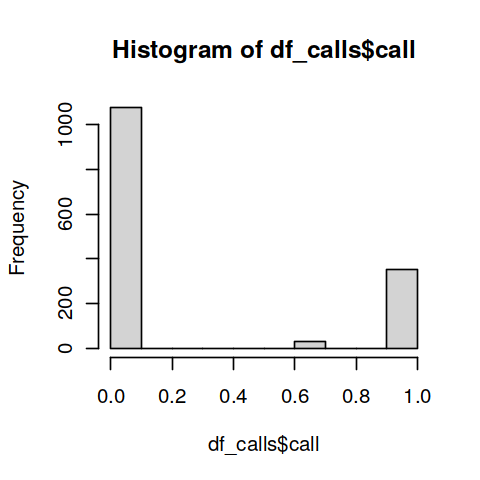

[1] 1076    3

threshold= 1

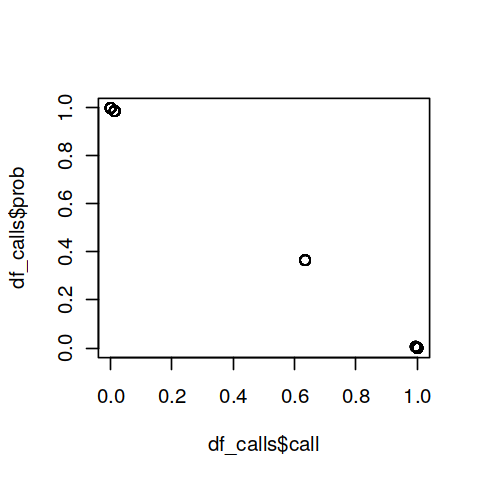

In [191]:
options(repr.plot.width=4, repr.plot.height=4)
CUTOFF_PROB = 0.5
head(df_calls)
dim(df_calls)
select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB
hist(df_calls$call)
plot(df_calls$call, df_calls$prob)

df_gauss = df_calls[select_gaussian_assigned,]
dim(df_gauss)
 
# head(df_gauss)
threshold = 2^min(df_gauss$log_count)
cat("threshold=", threshold)

In [192]:
filter_y = y > 2
y_filtered = y[filter_y]
df_y = as.data.frame(y_filtered)
head(df_y)

y_filtered
1  4        
2 16        
3  3        
4  3        
5  9        
6  3

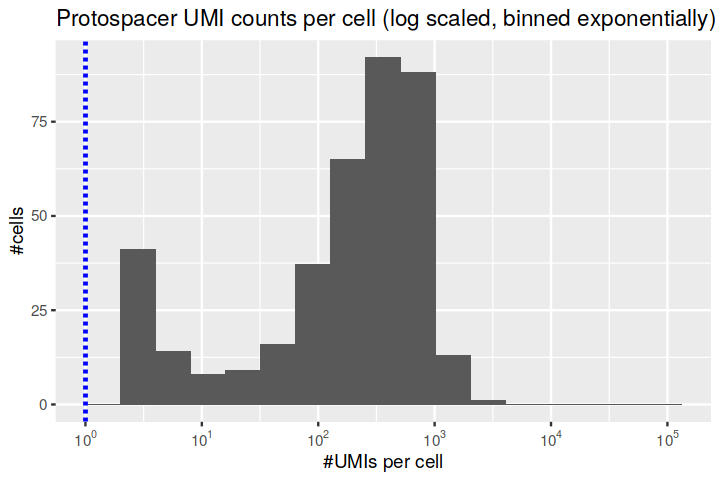

In [193]:
options(repr.plot.width=6, repr.plot.height=4)
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +  geom_vline(aes(xintercept=threshold), color="blue", linetype="dashed", size=1)

ggp1

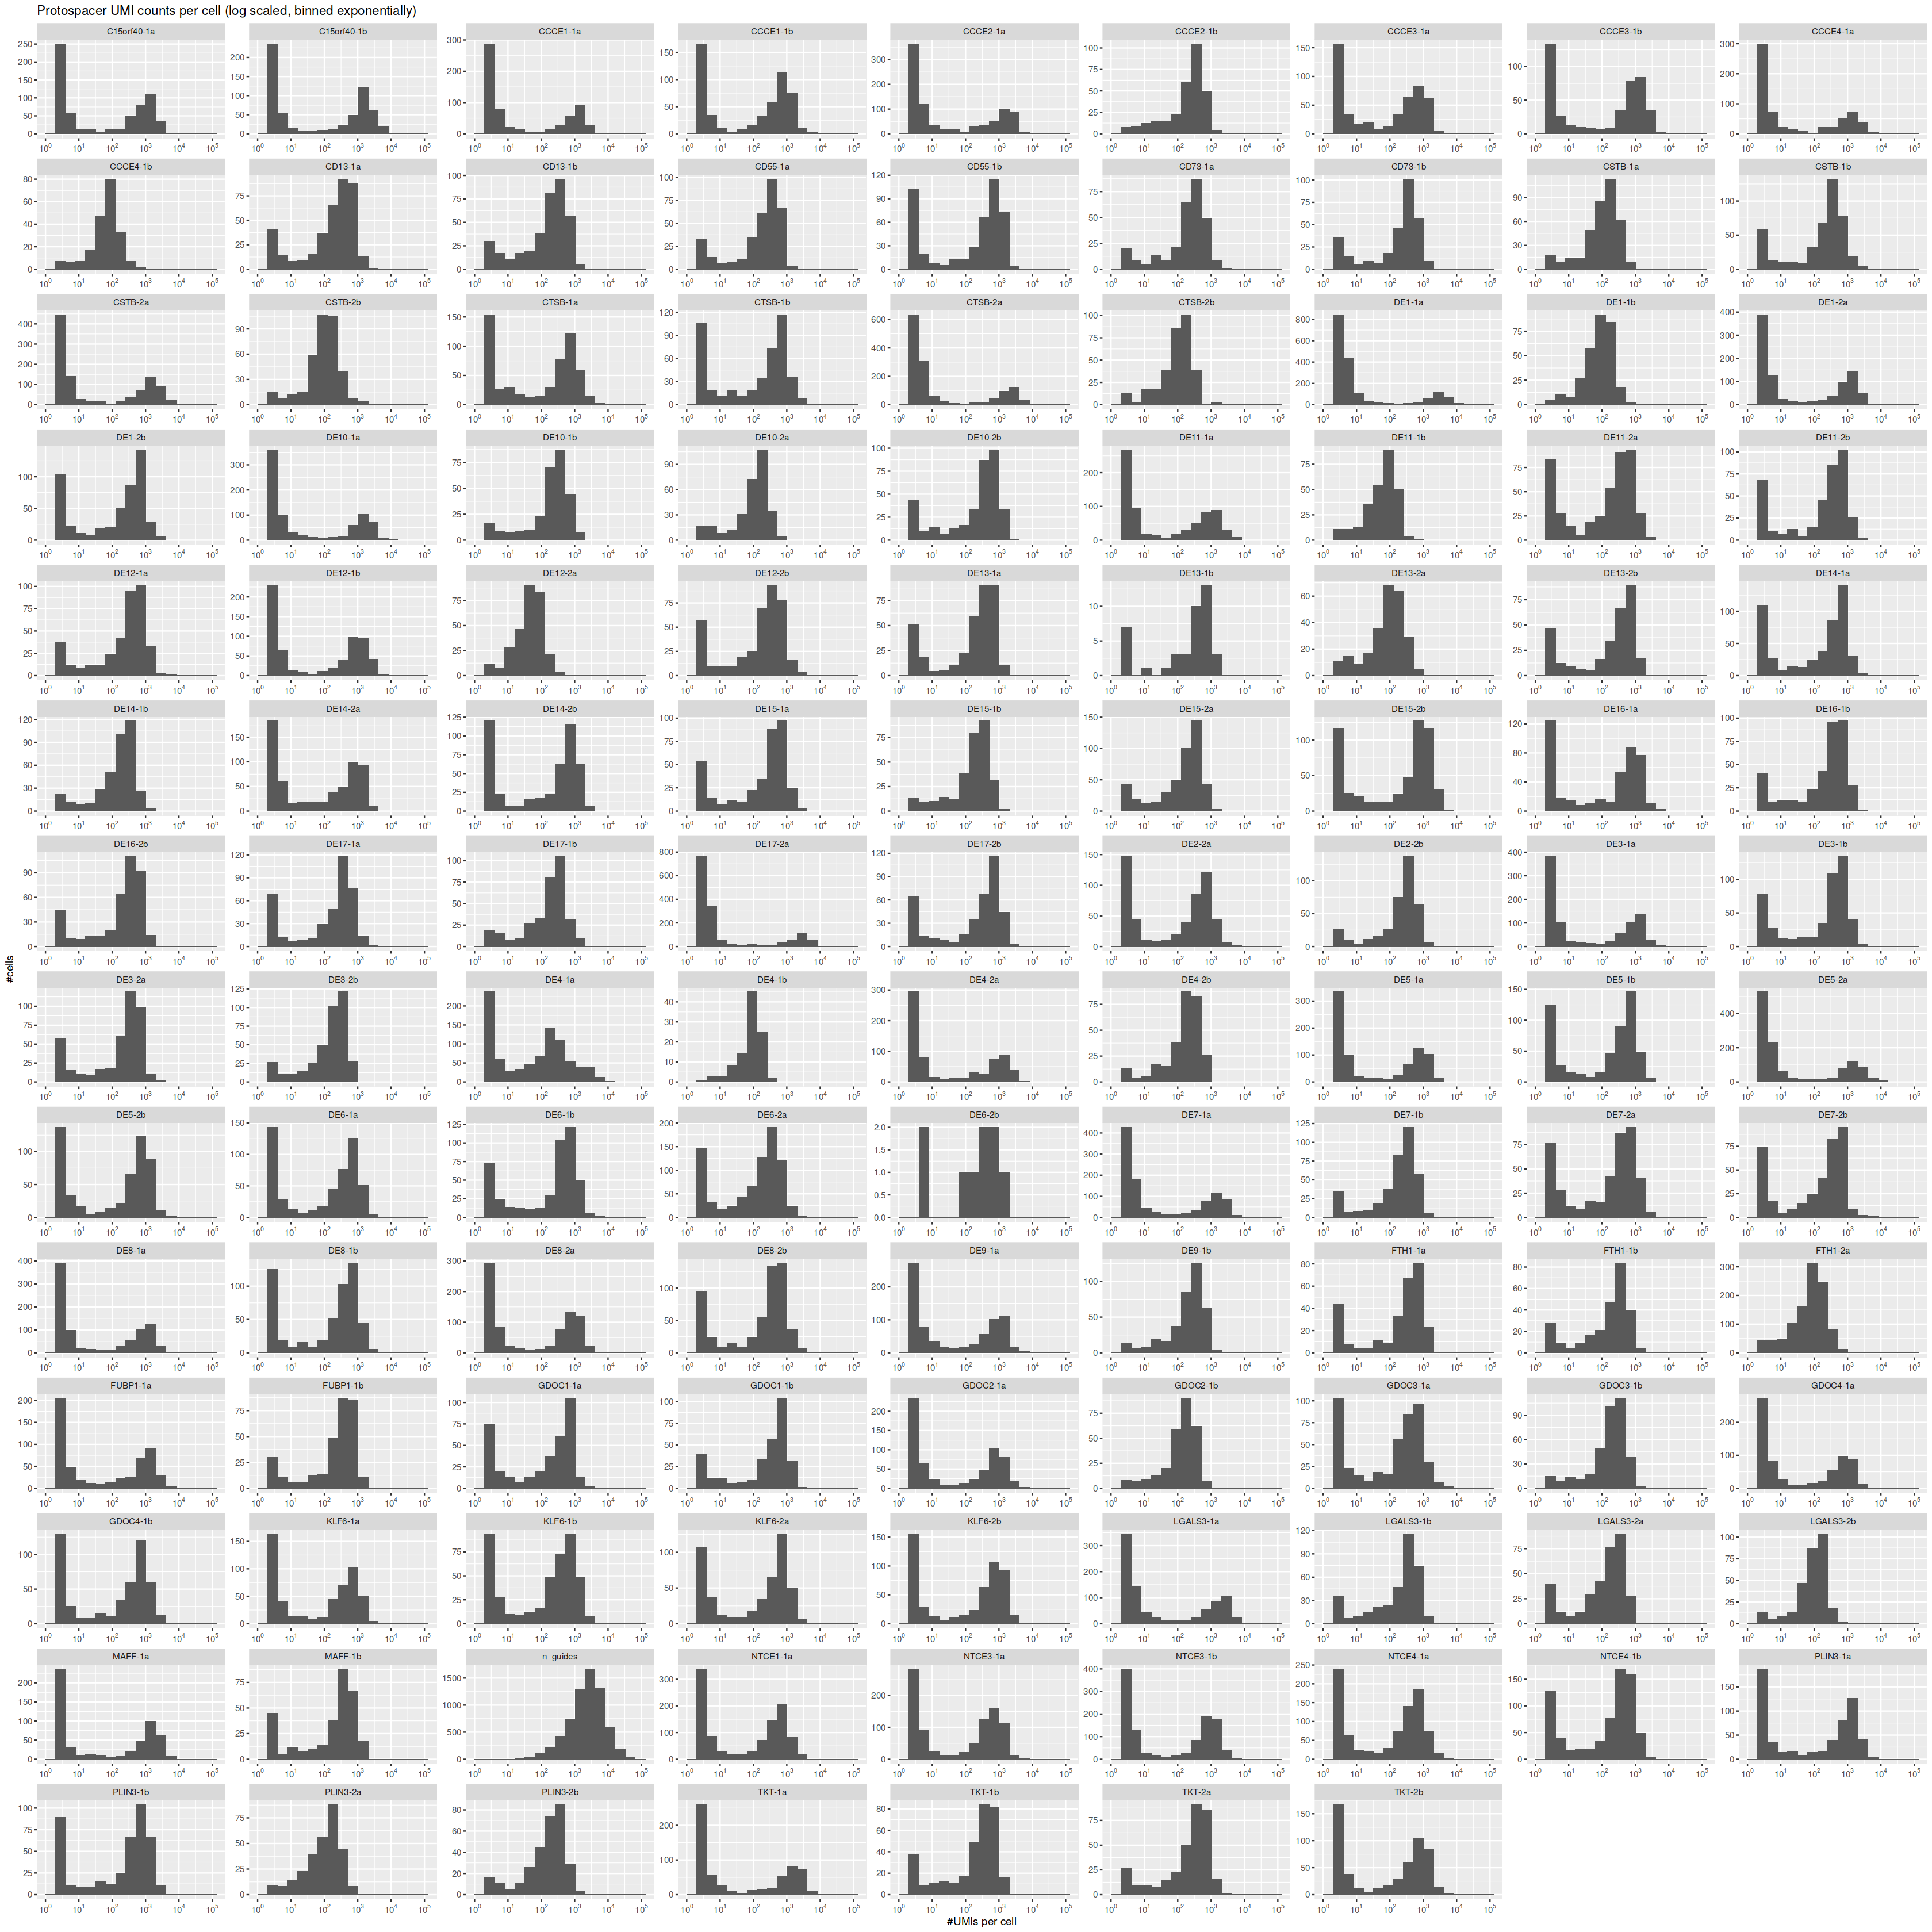

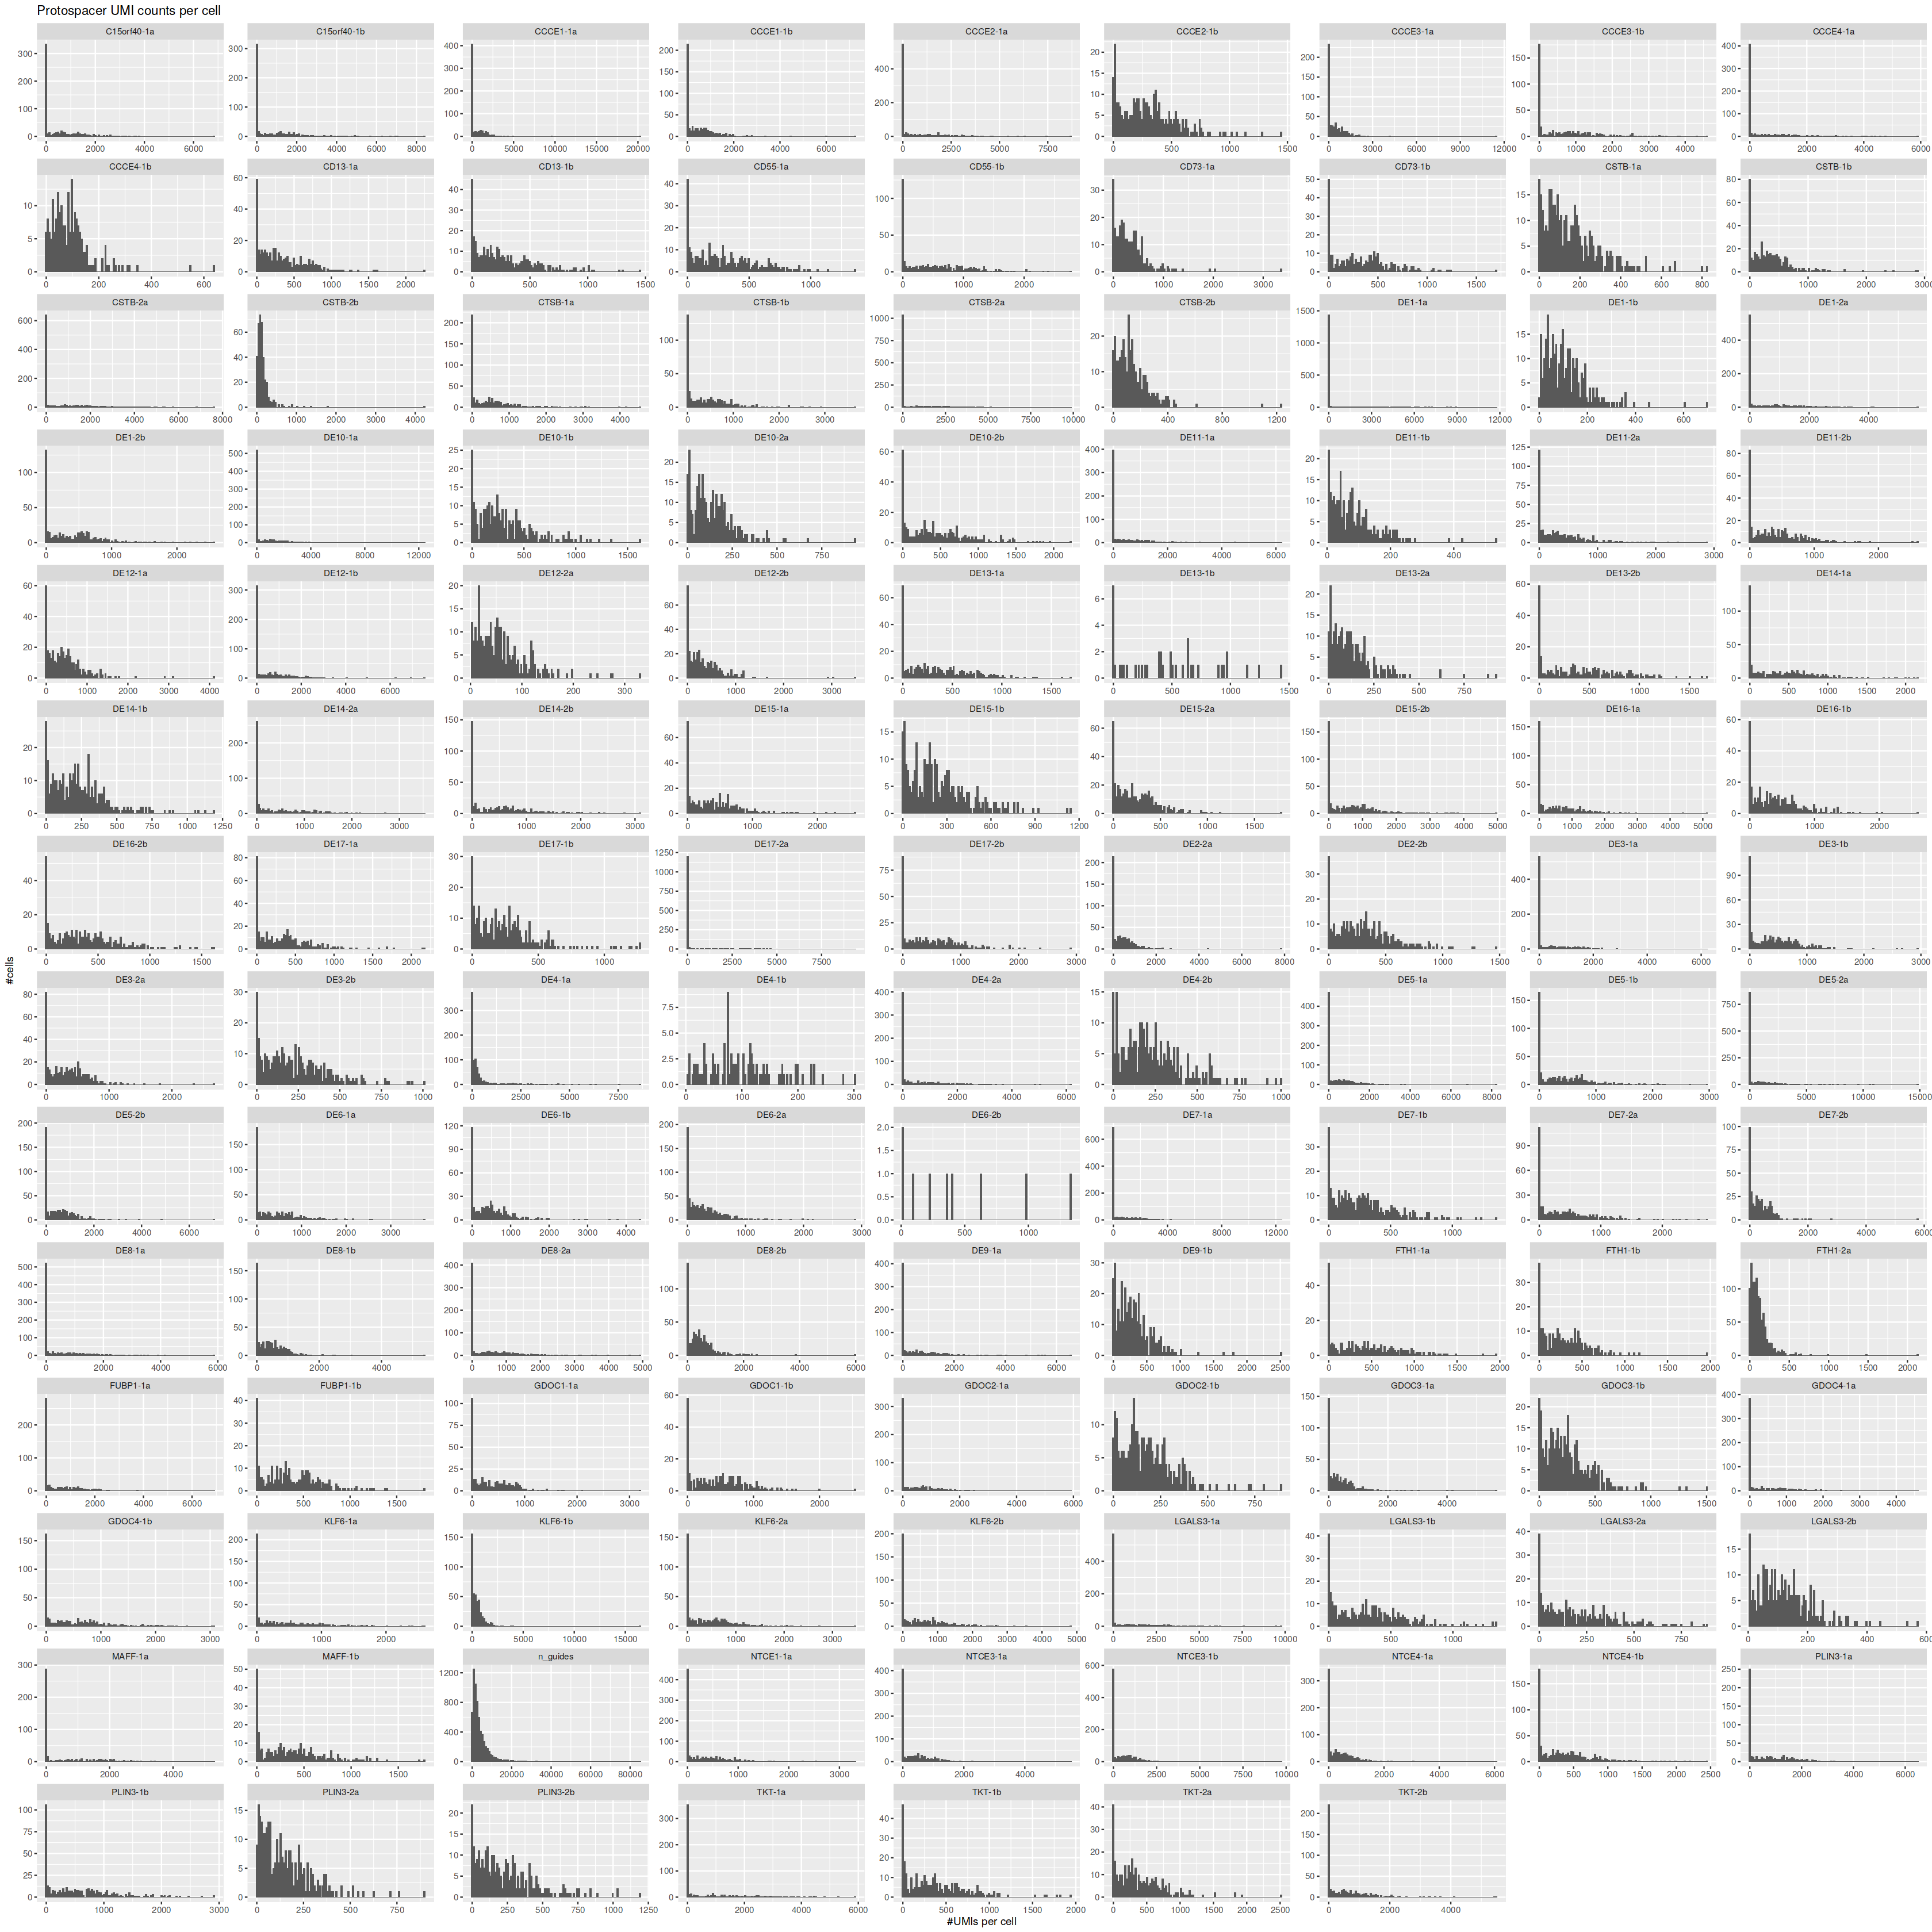

In [194]:
options(repr.plot.width=28, repr.plot.height=28)

data_long <- df_guide_counts %>%                    
  pivot_longer(colnames(df_guide_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp1
ggp2

# Call all guides

In [195]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

In [196]:
head(df_guide_counts)

CD13-1a CD13-1b CD55-1a CD55-1b CD73-1a CD73-1b FUBP1-1a FUBP1-1b C15orf40-1a
1 0       0       0       0       0       0       0        0          57       
2 0       0       0       2       0       0       0        0        1383       
3 0       0       0       0       0       0       1        0        1302       
4 0       0       0       0       0       0       0        0         428       
5 0       0       0       0       0       0       0        0        1515       
6 0       0       0       0       0       0       0        0         606       
  C15orf40-1b ⋯ GDOC4-1b CCCE1-1a CCCE1-1b CCCE2-1a CCCE2-1b CCCE3-1a CCCE3-1b
1    0        ⋯ 0        0        0        1        0        1        0       
2    0        ⋯ 0        0        0        0        0        0        0       
3 1753        ⋯ 1        0        1        1        0        0        1       
4 1565        ⋯ 0        0        0        1        0        0        0       
5 3322        ⋯ 0        0        0        0        0        0        1       
6 1592        ⋯ 0        0        0        0        0        0        0       
  CCCE4-1a CCCE4-1b n_guides
1 0        0          92    
2 1        0        1412    
3 2        0        3081    
4 0        0        2006    
5 1        0        4873    
6 0        0        2212

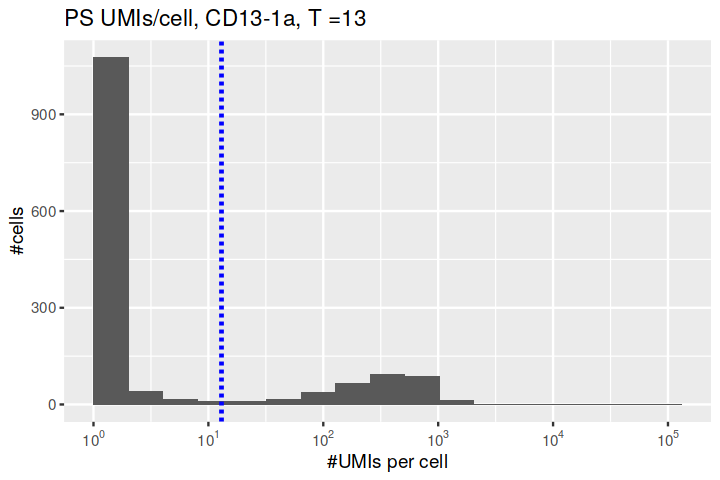

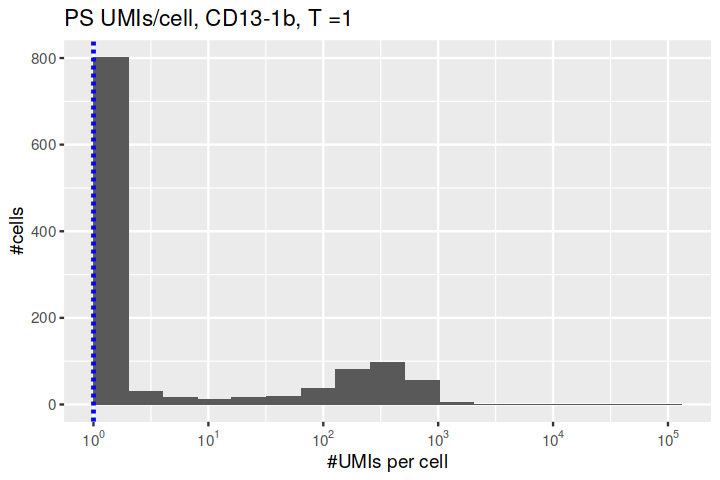

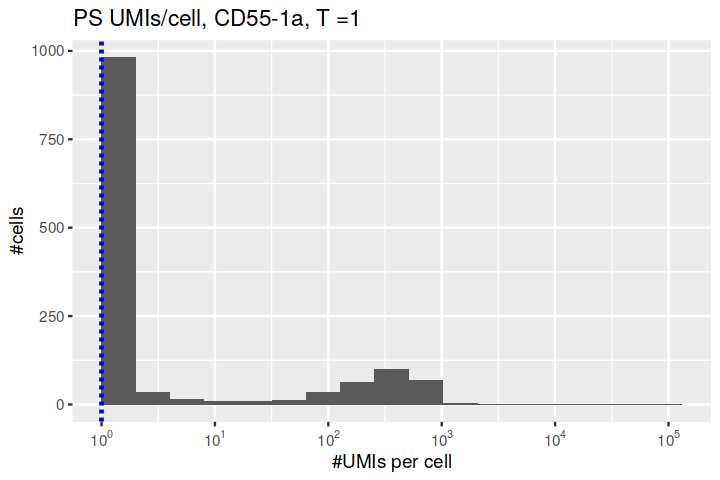

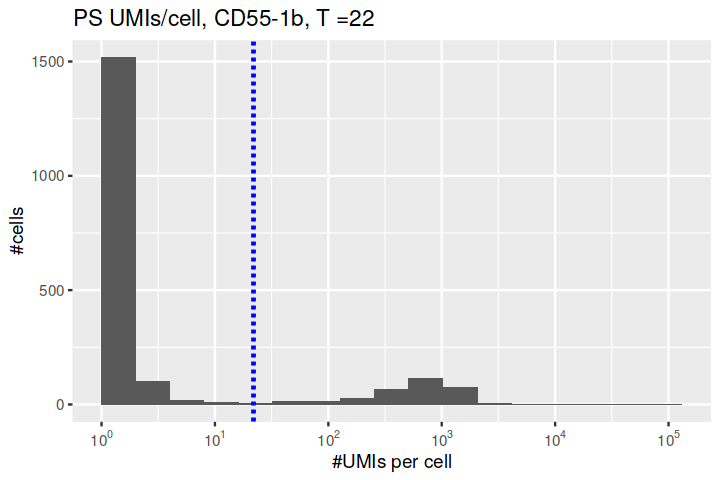

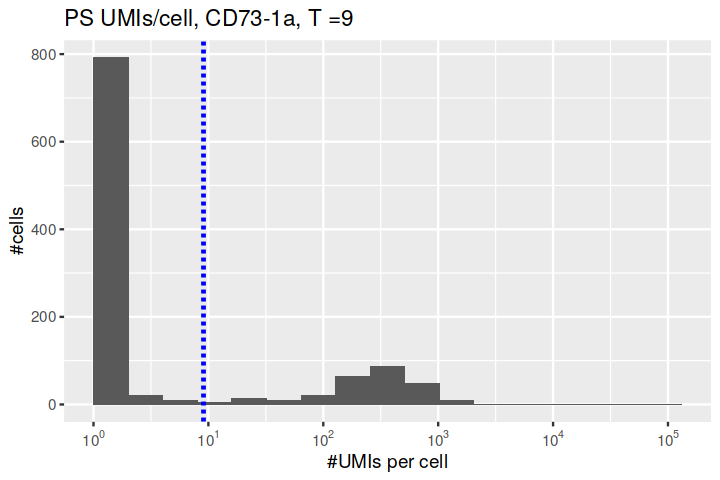

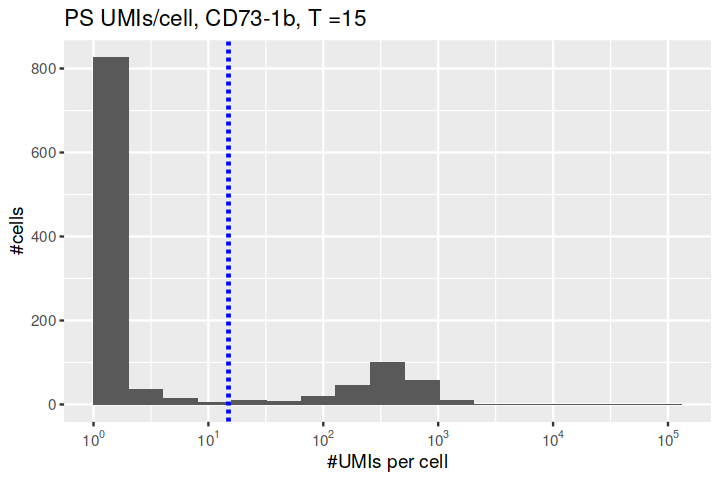

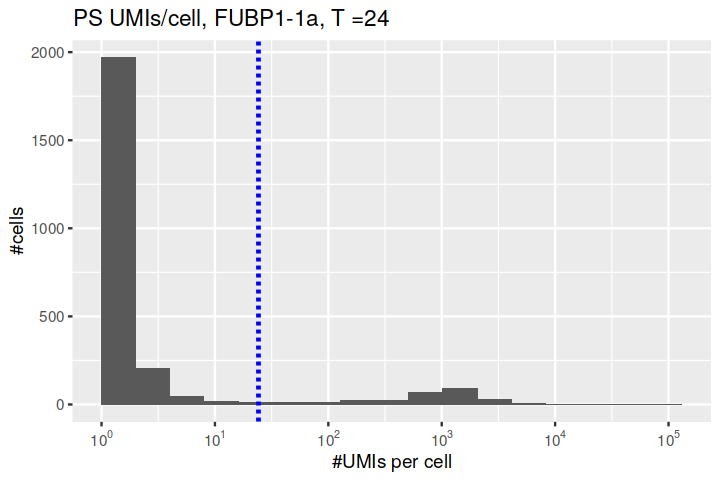

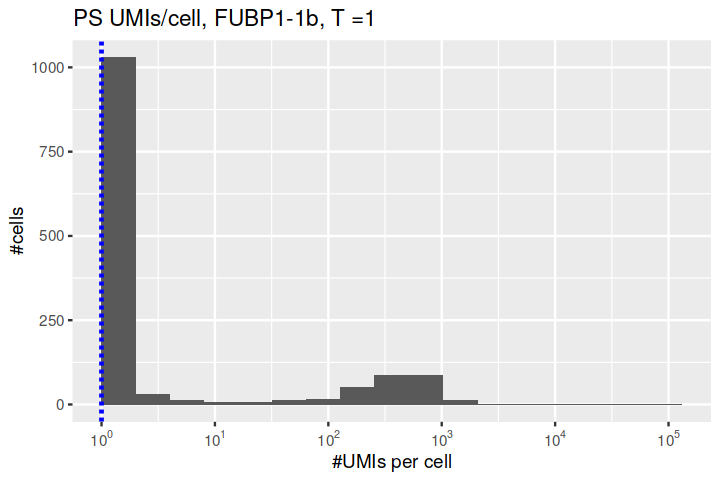

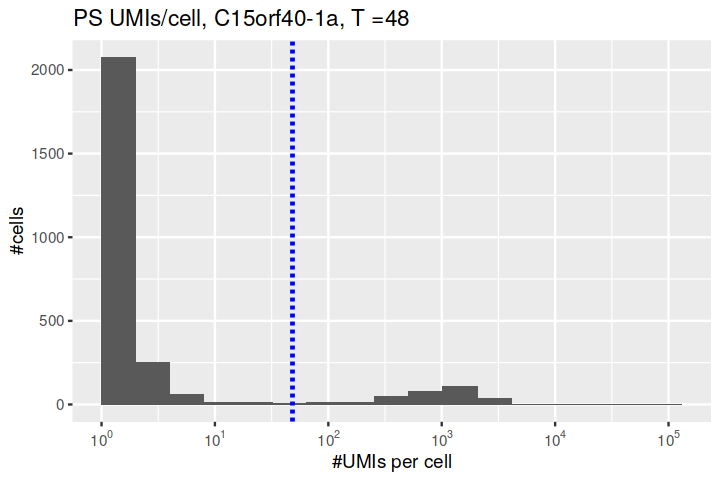

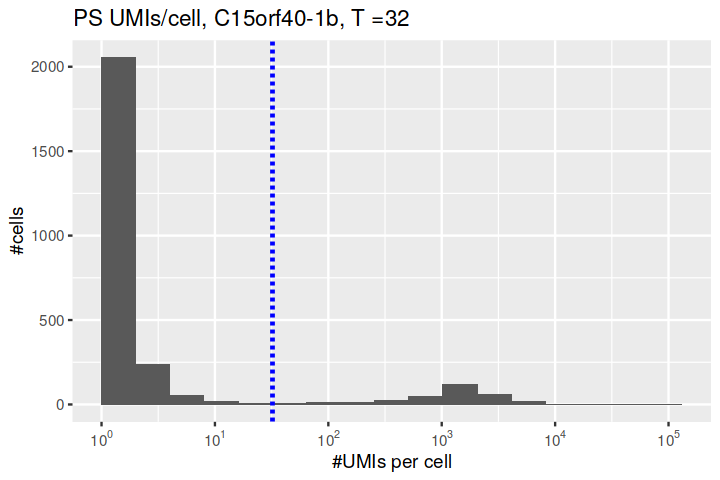

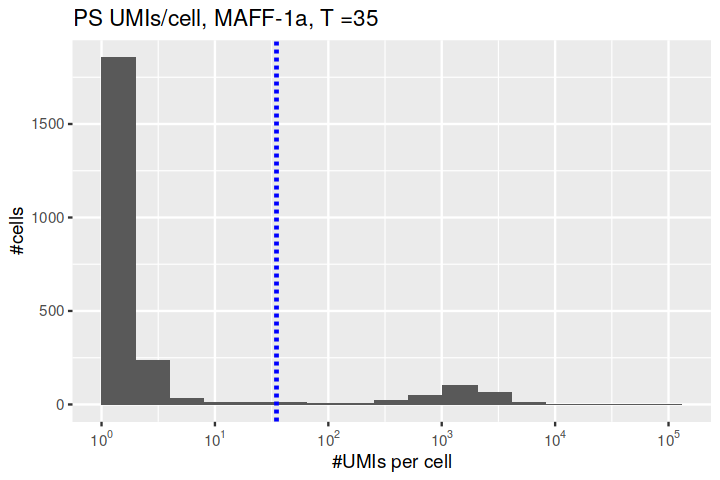

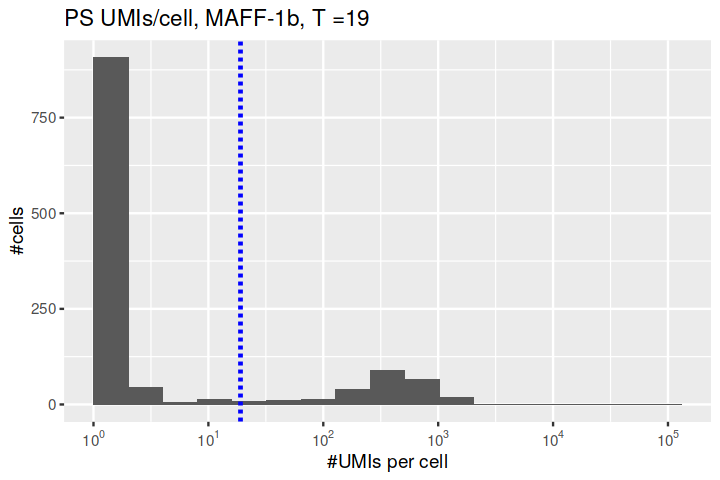

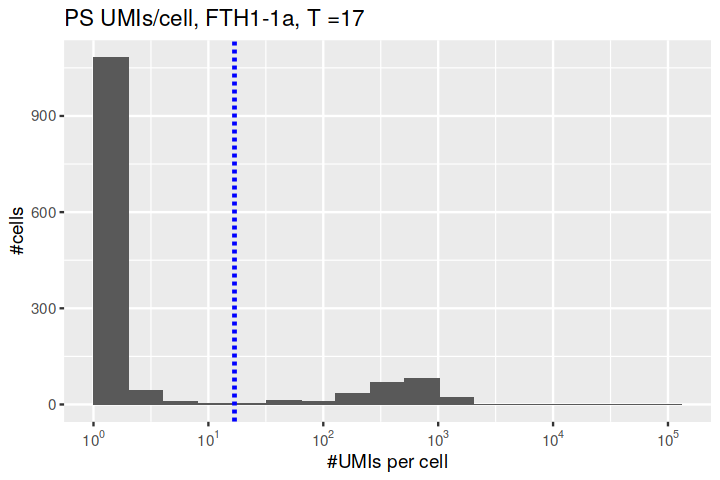

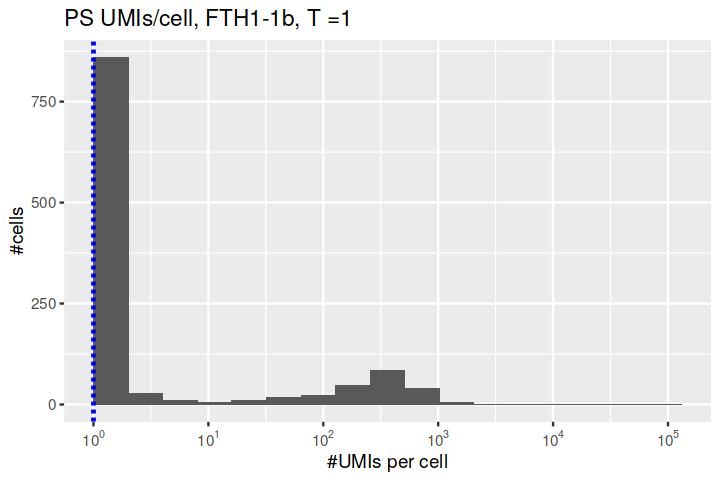

Skipping FTH1-2b 


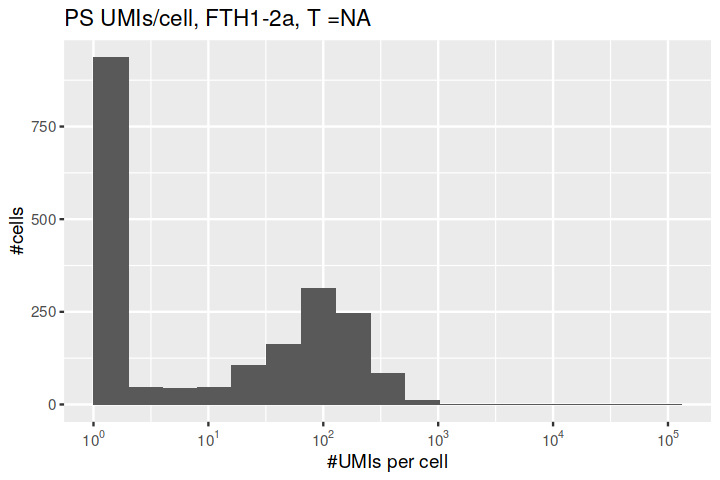

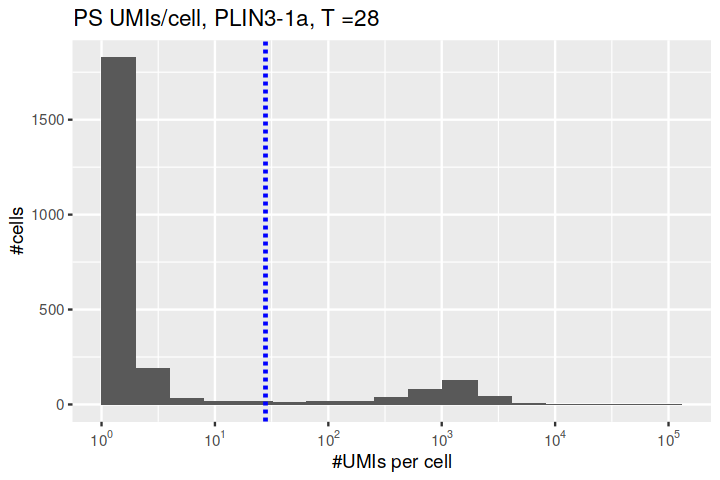

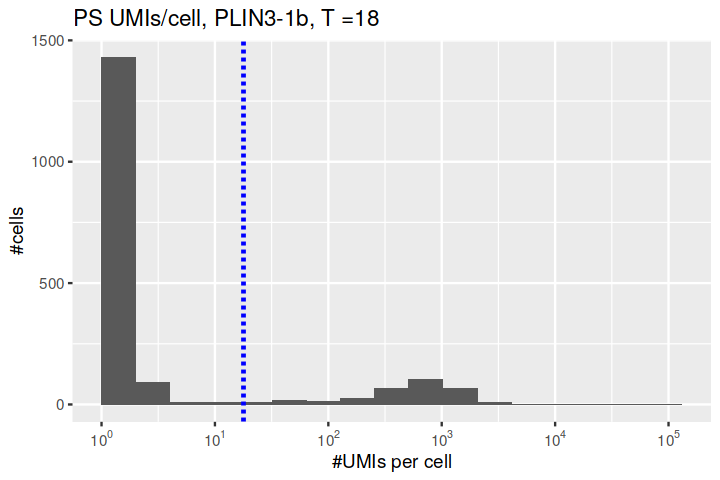

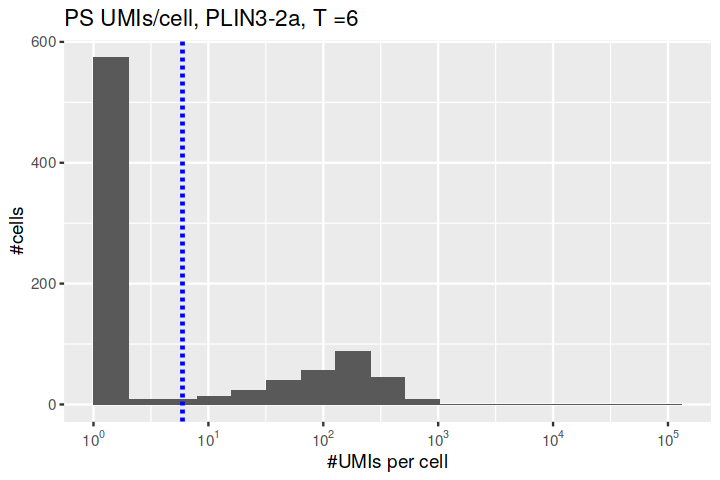

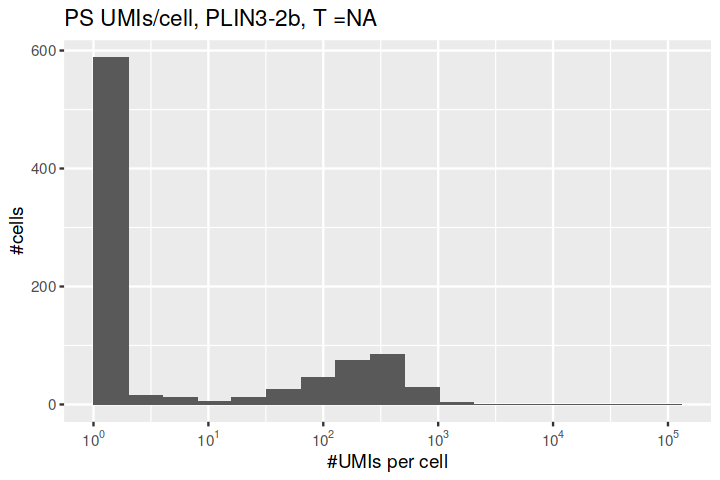

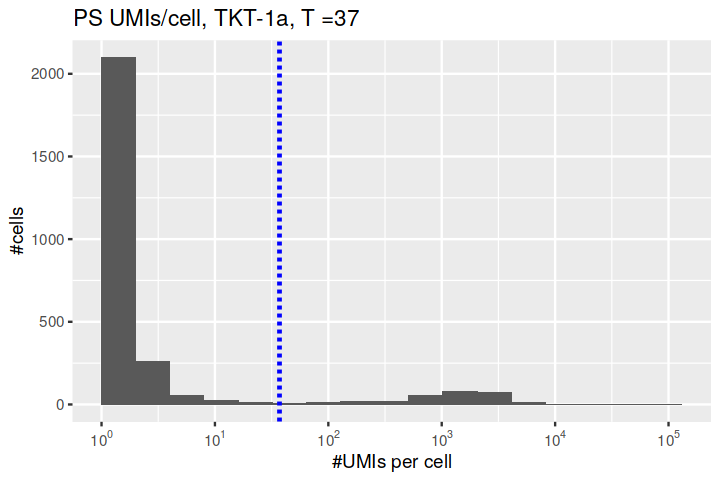

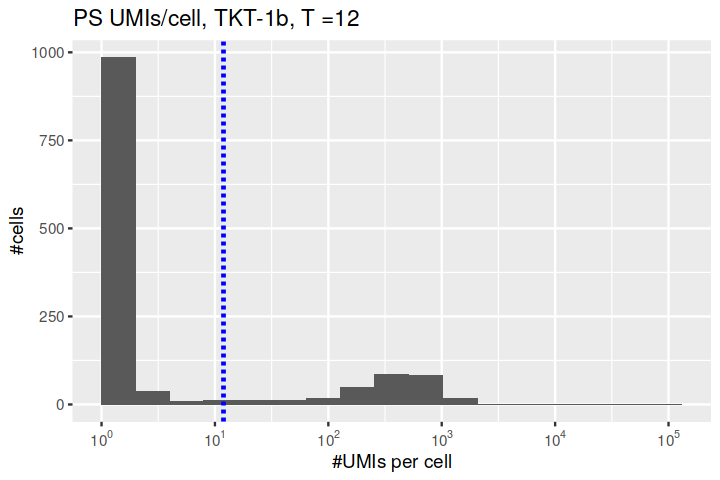

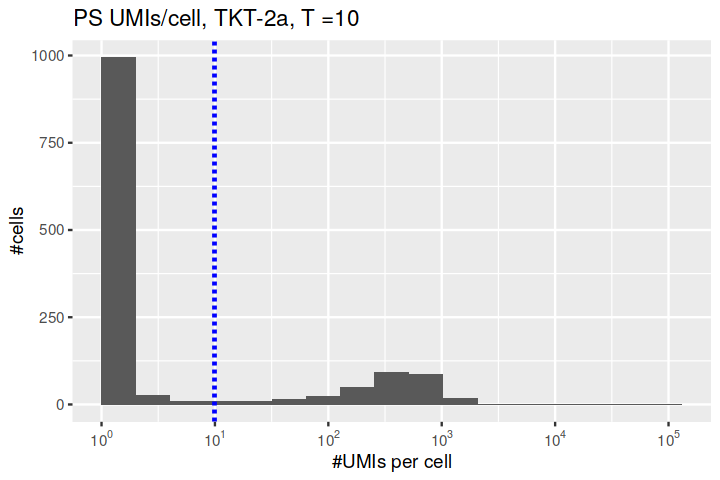

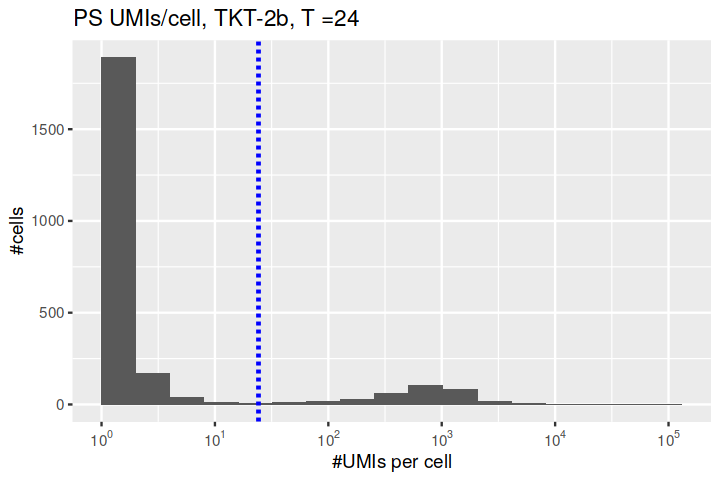

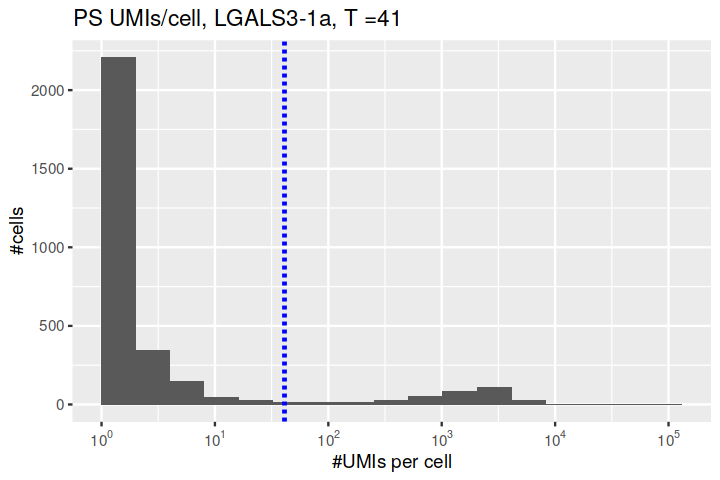

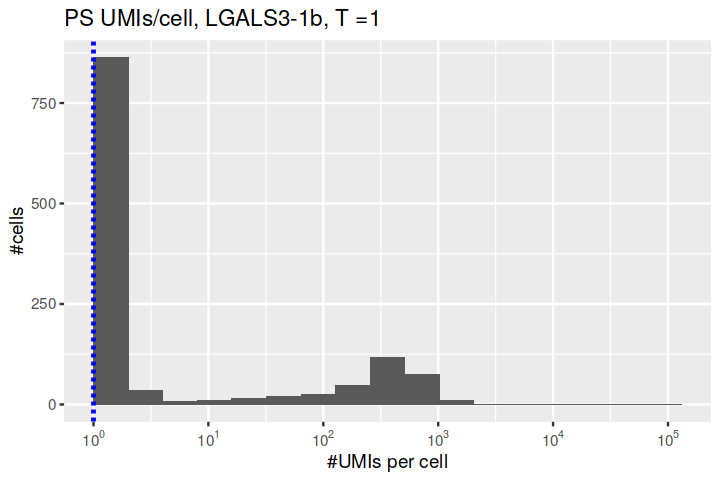

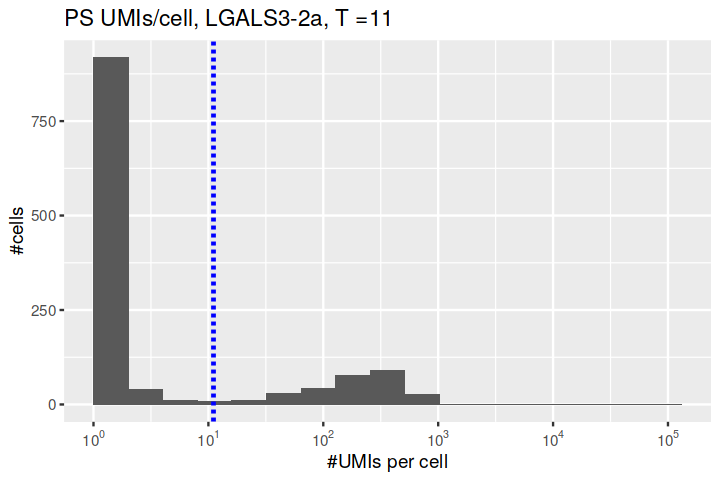

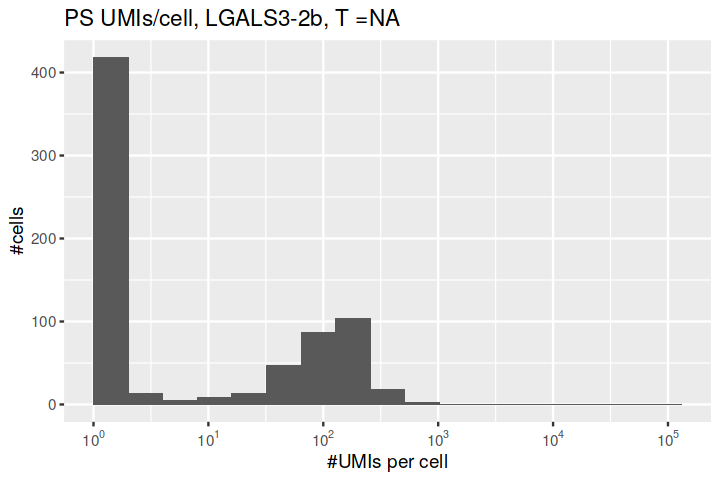

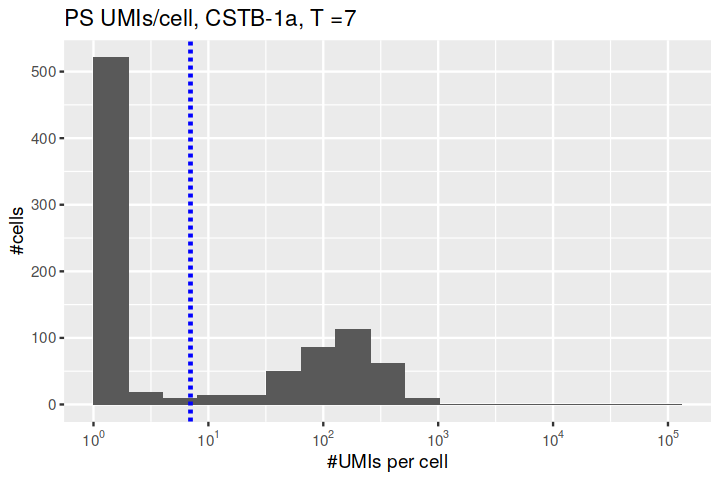

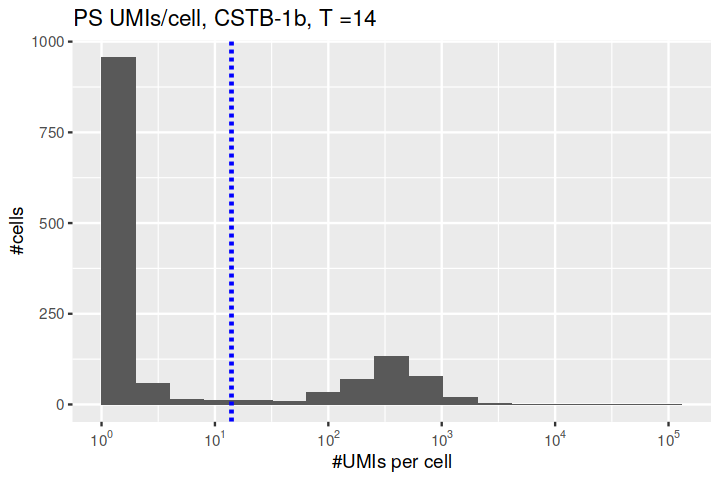

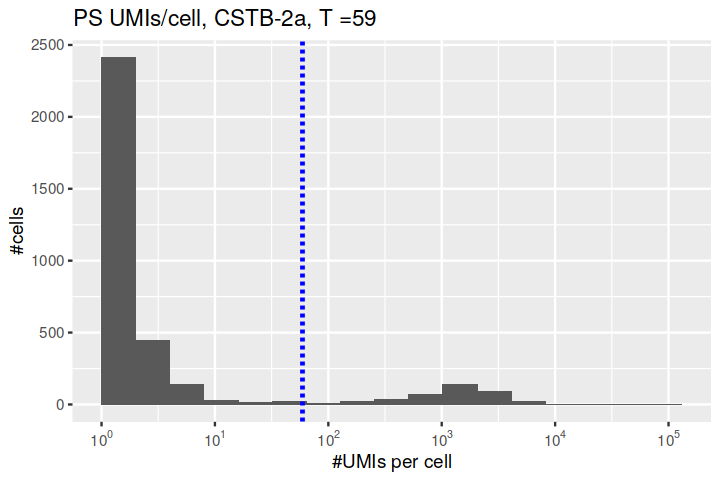

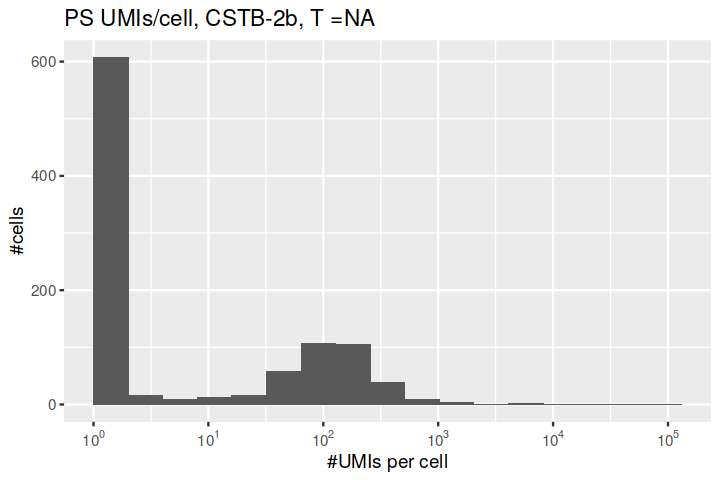

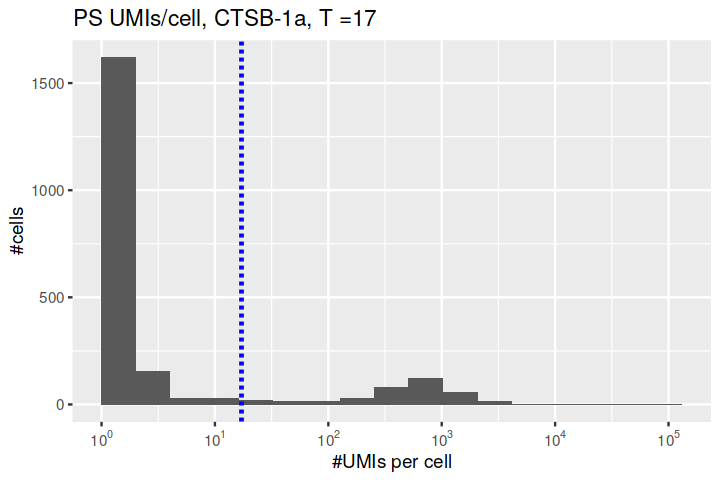

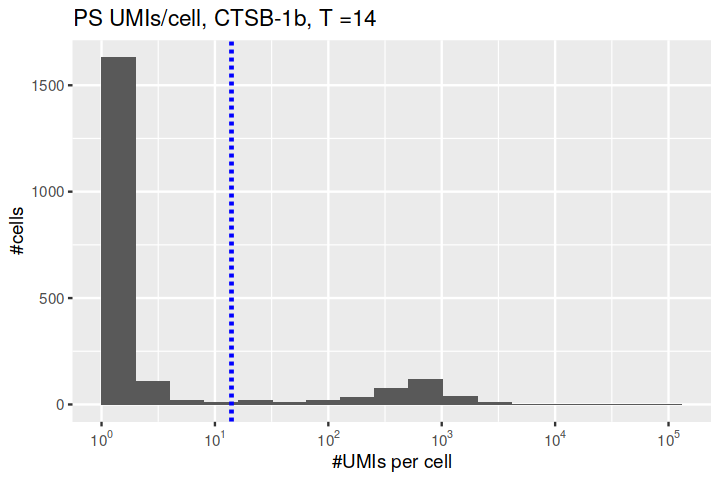

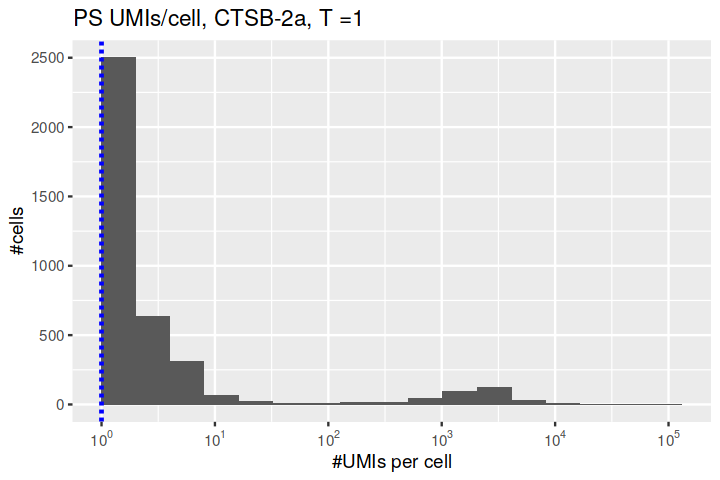

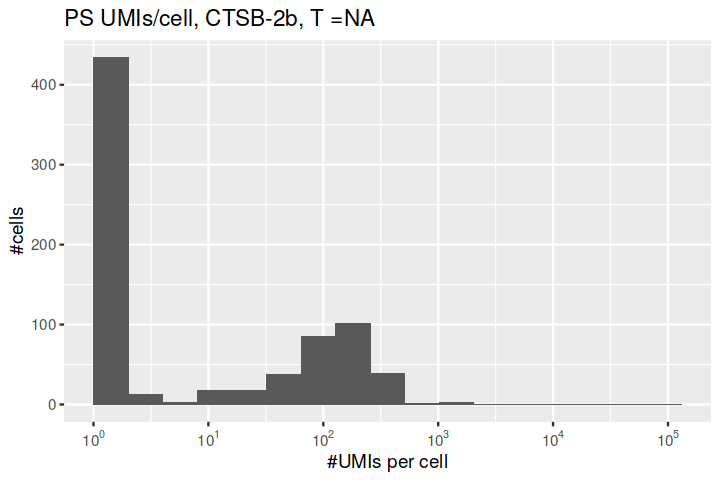

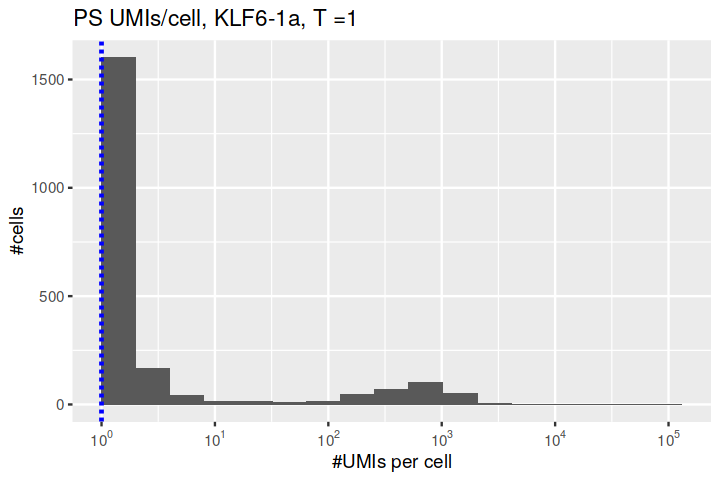

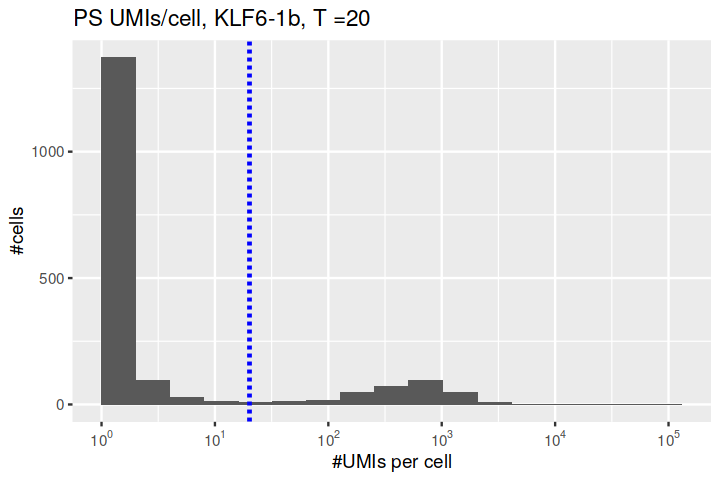

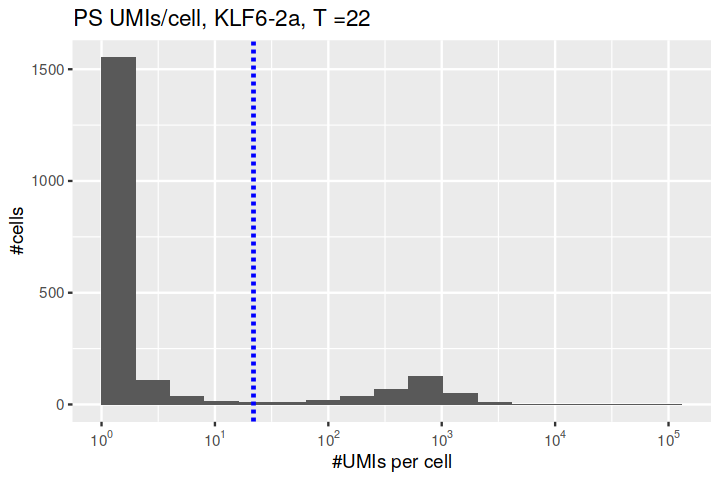

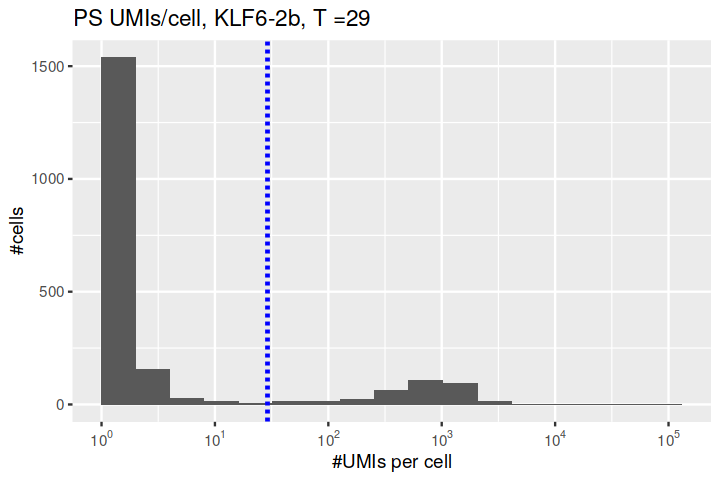

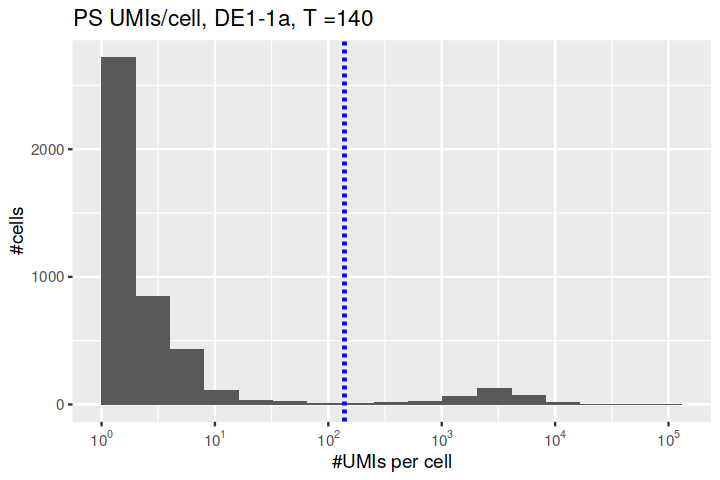

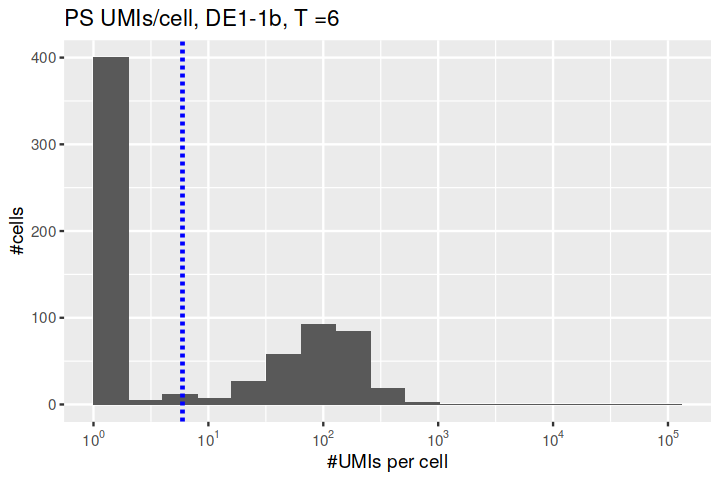

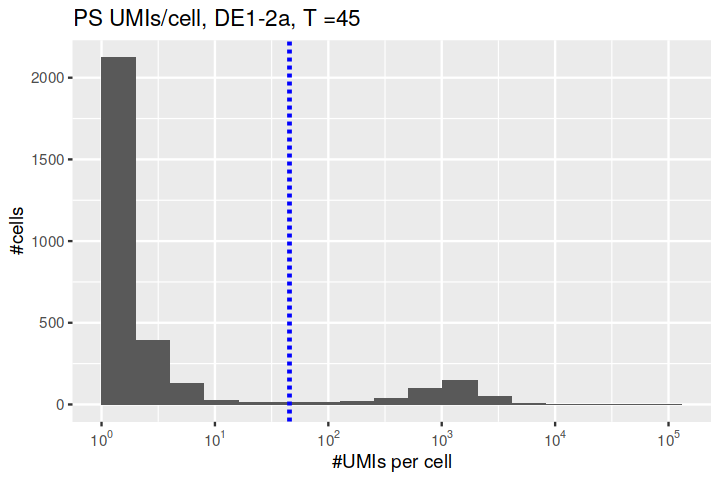

Skipping DE2-1a 
Skipping DE2-1b 


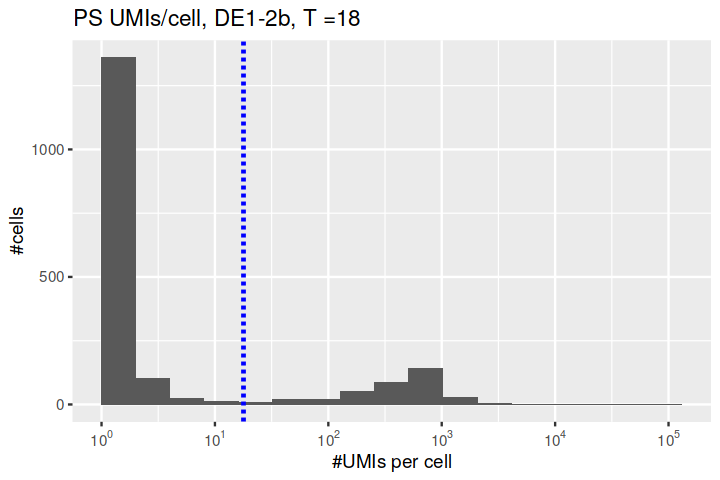

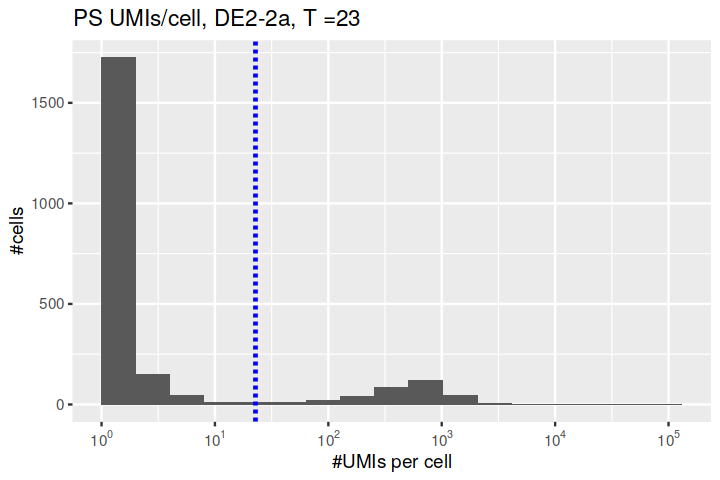

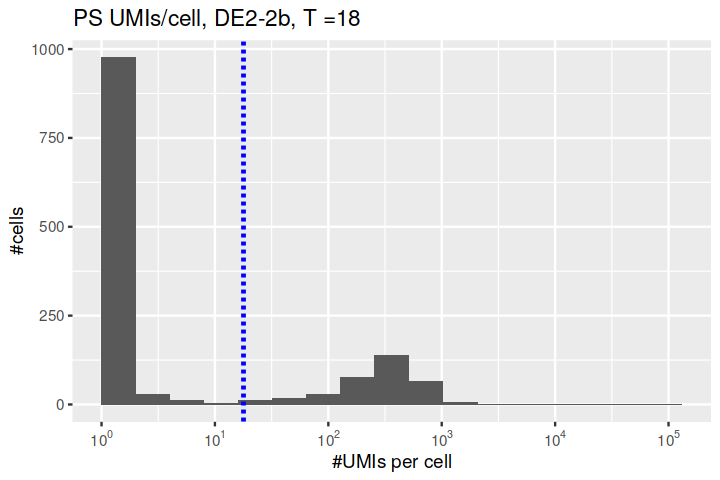

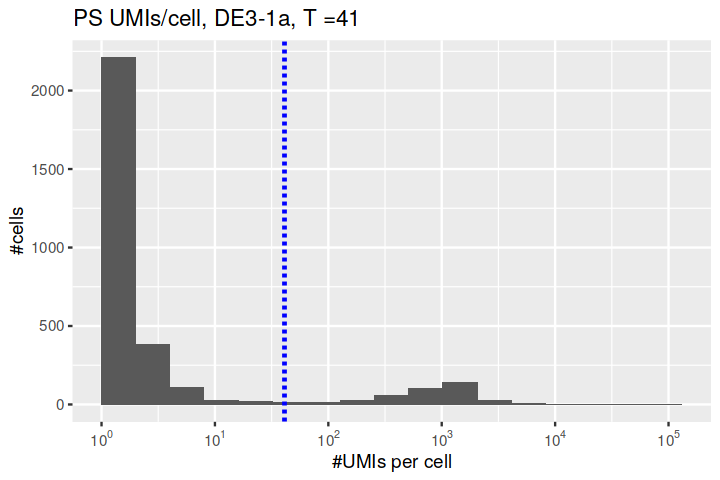

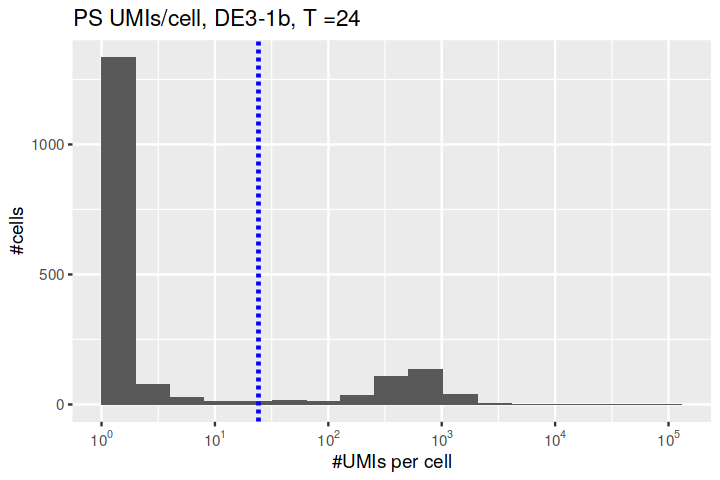

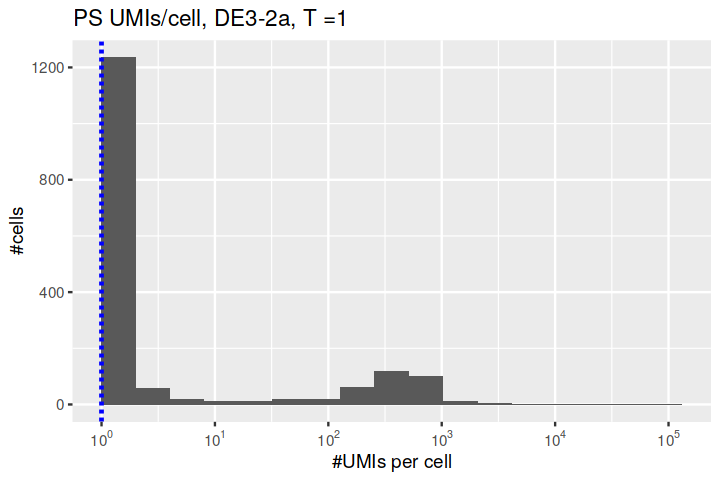

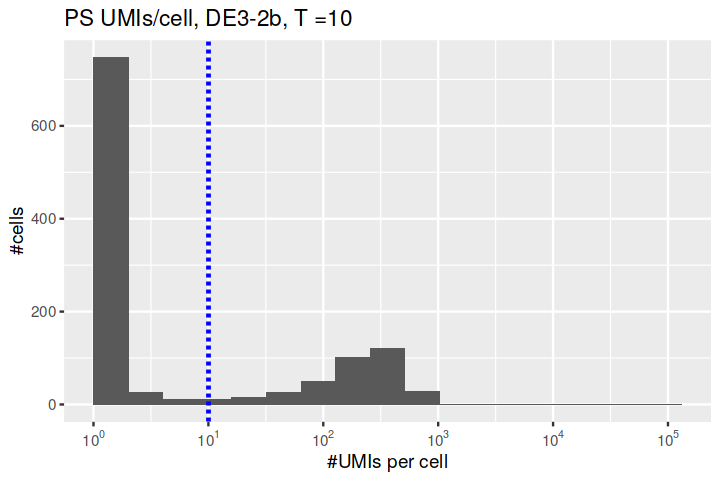

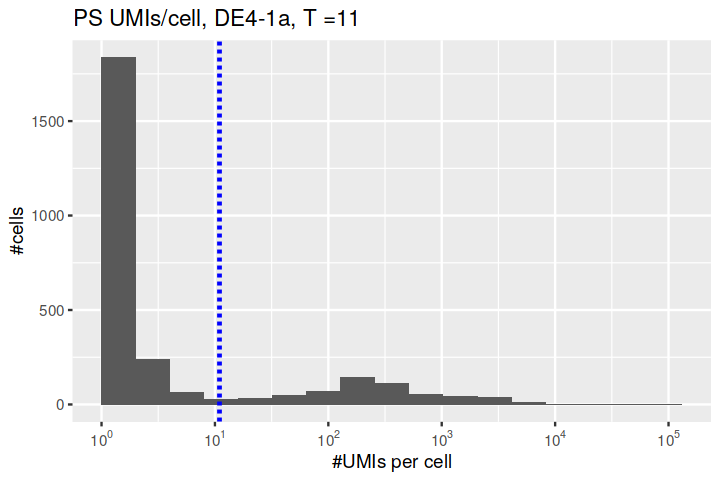

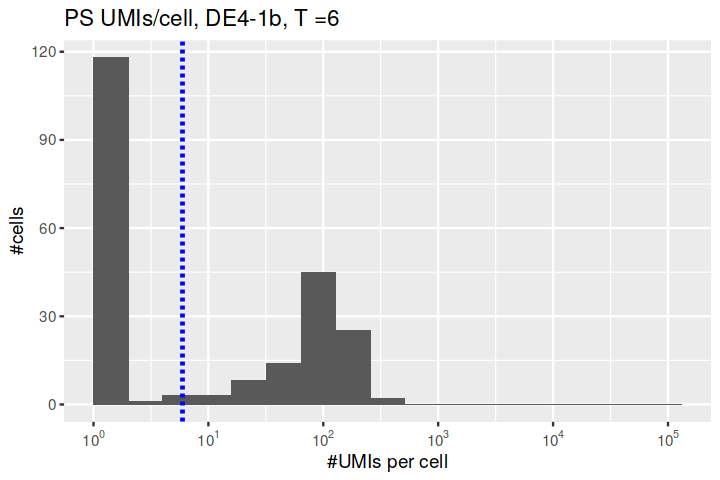

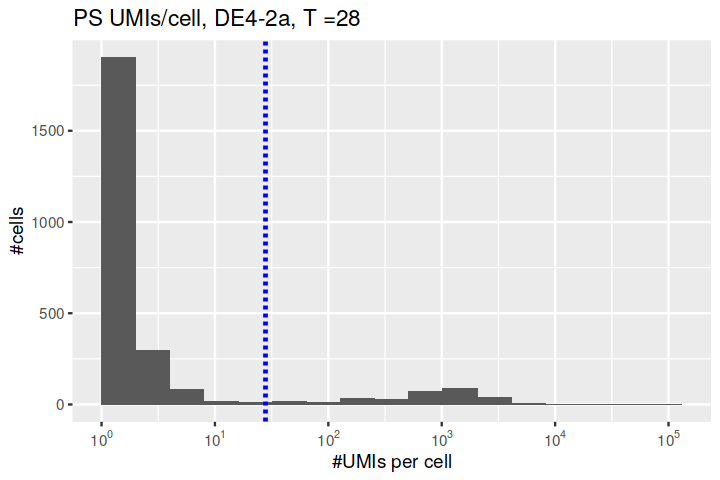

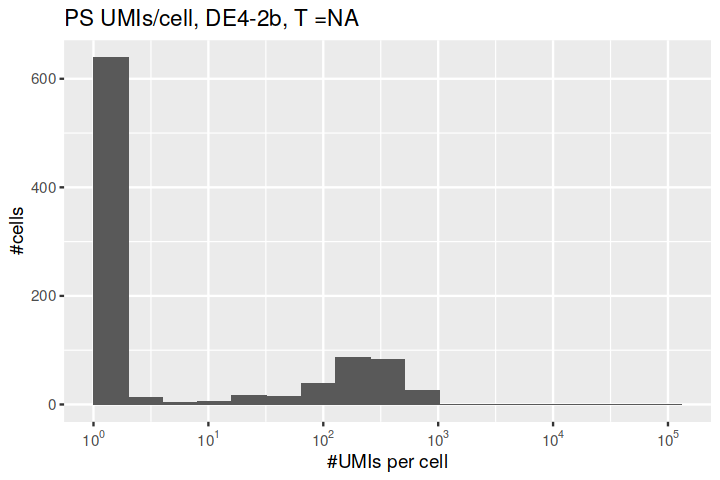

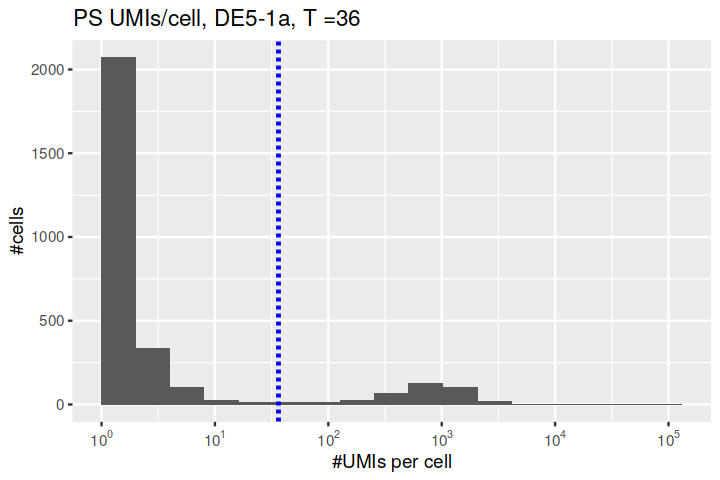

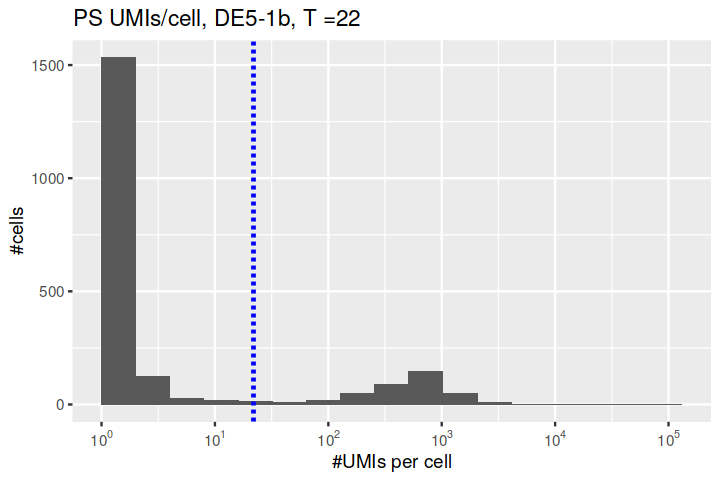

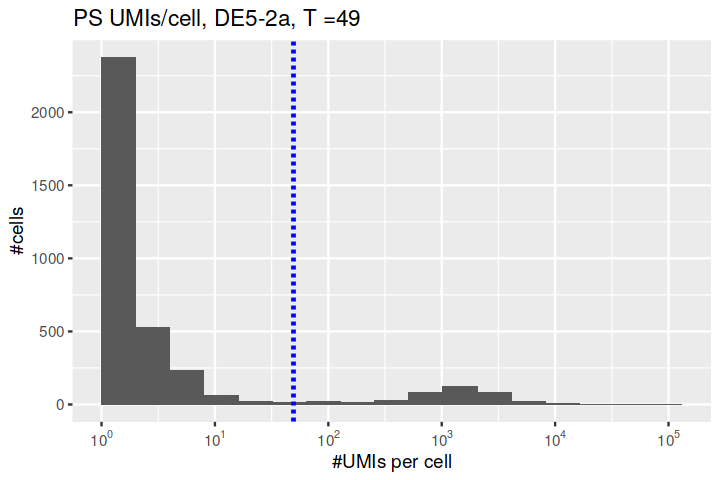

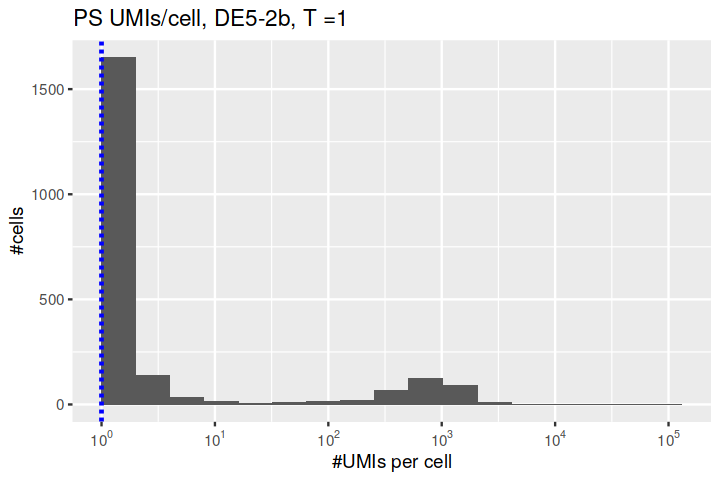

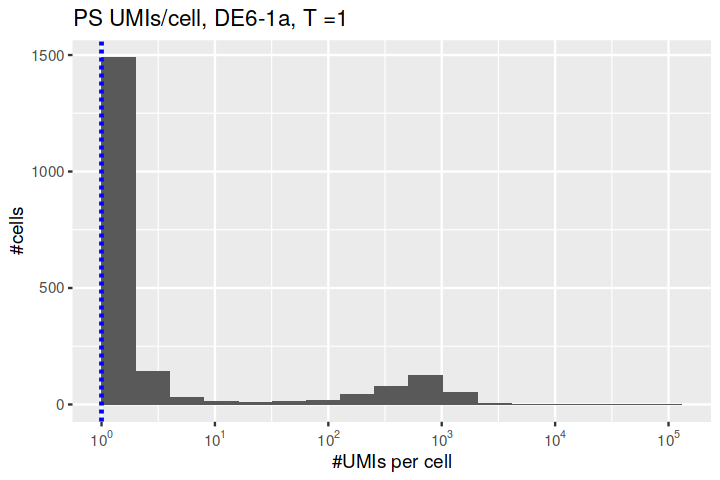

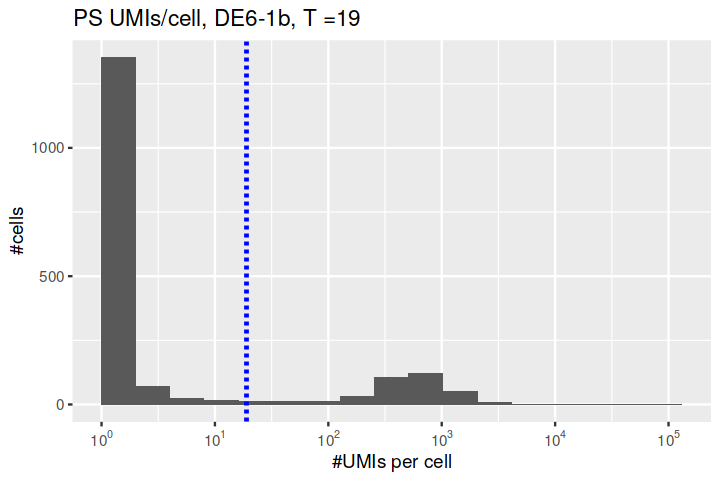

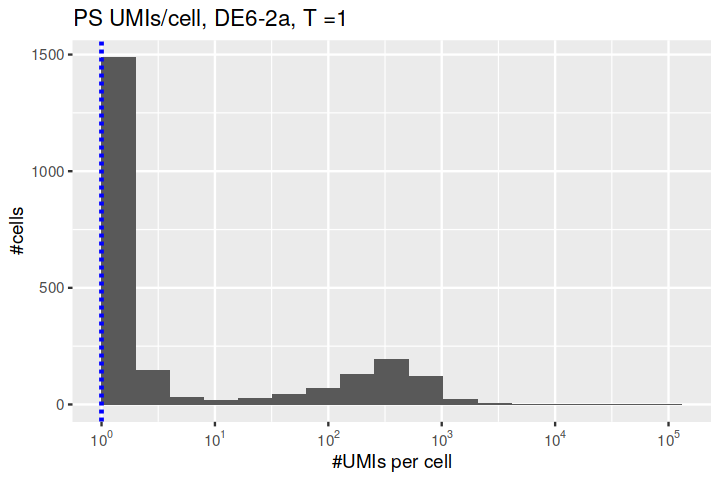

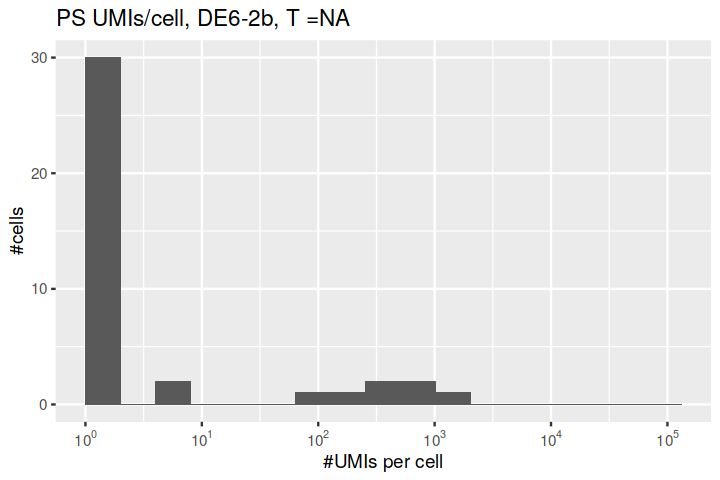

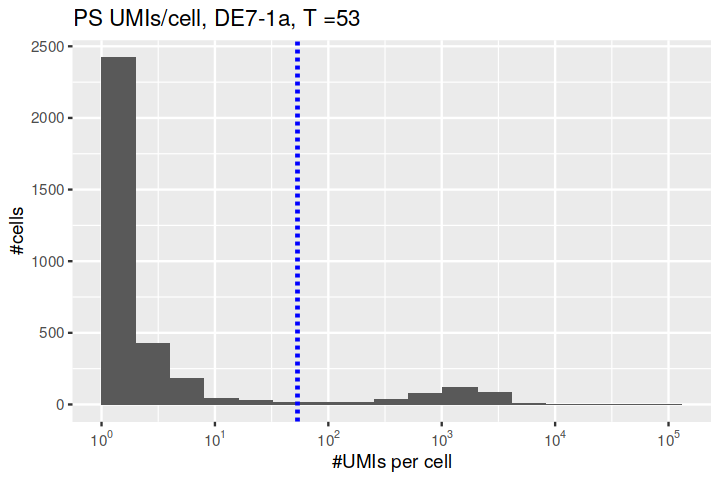

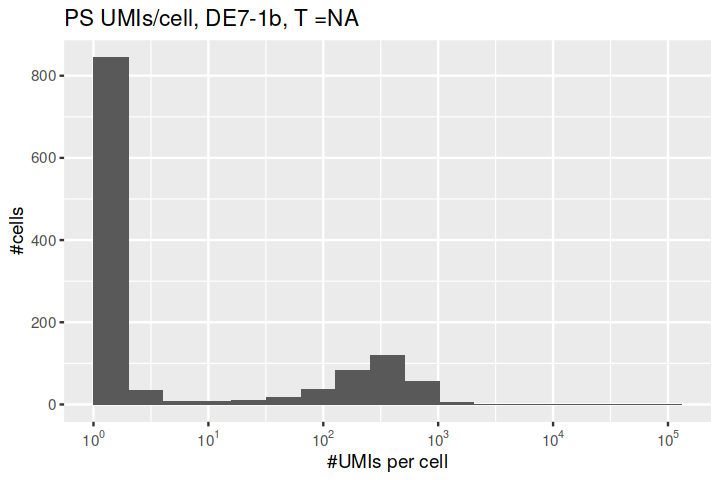

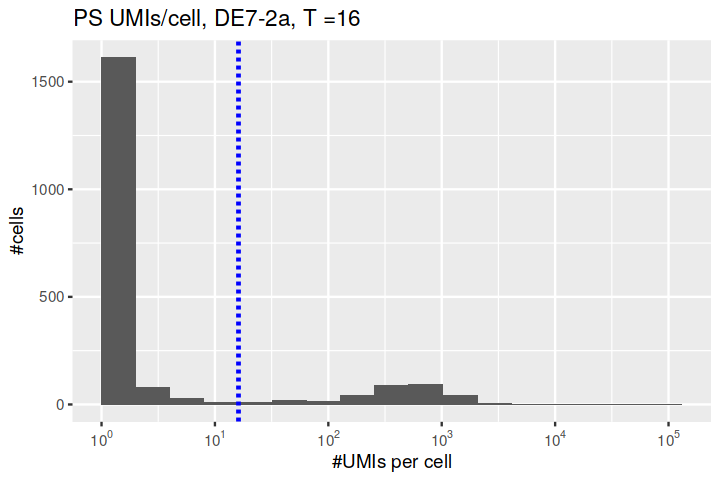

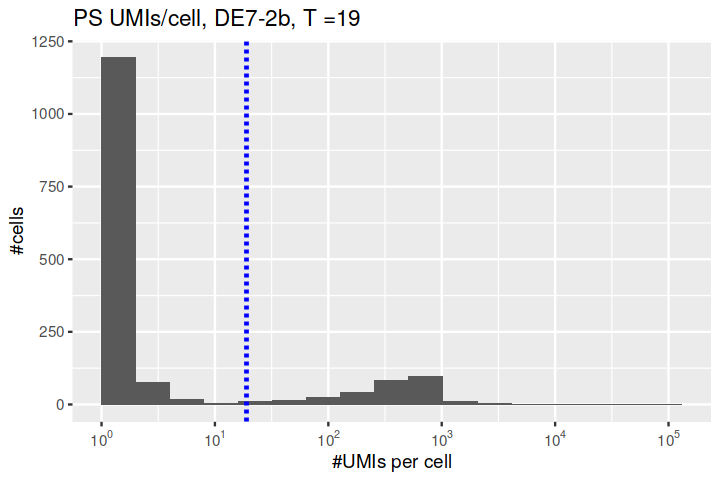

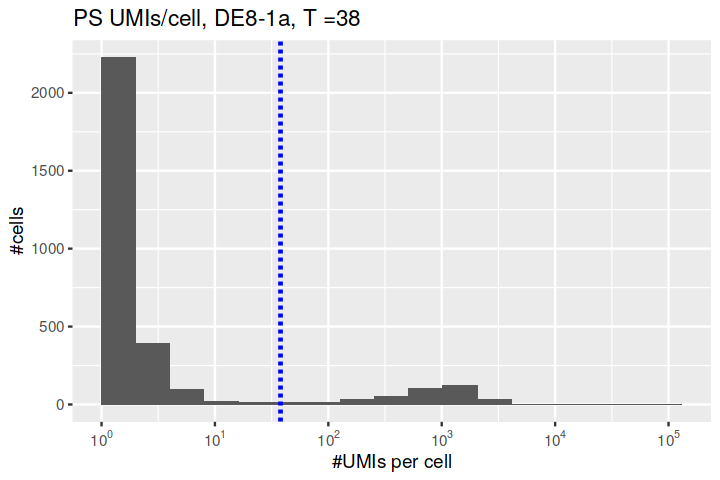

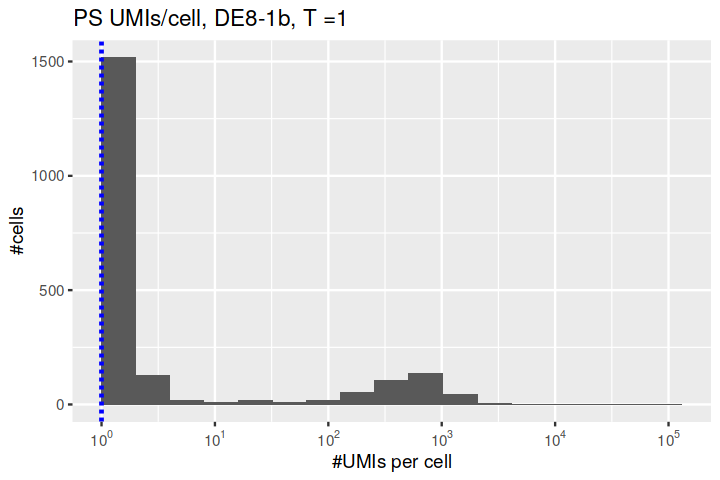

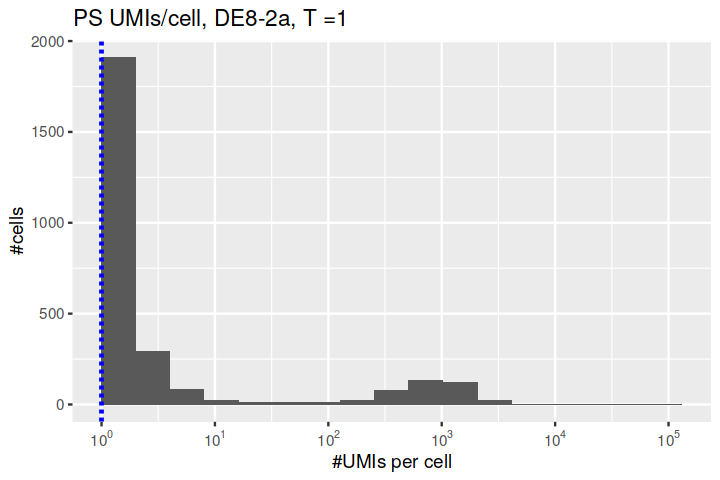

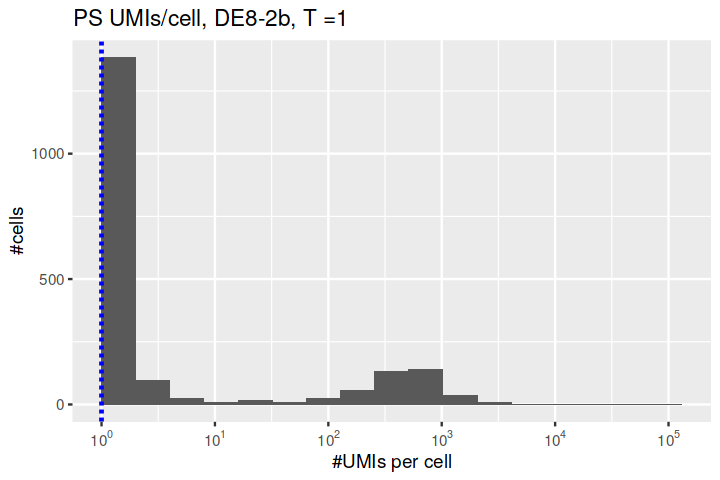

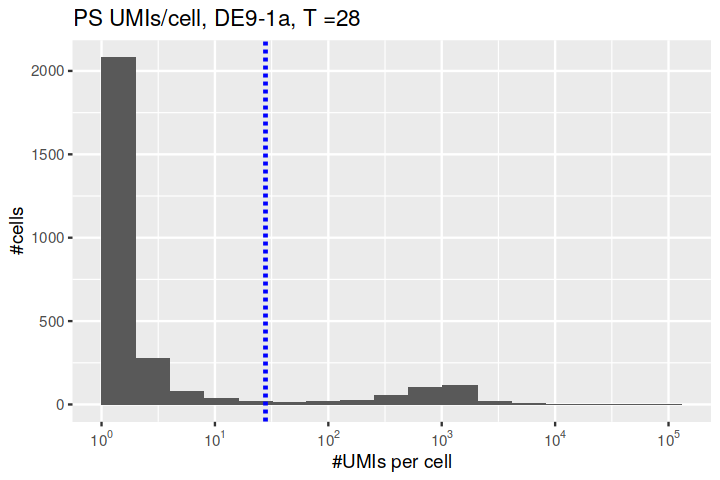

Skipping DE9-2a 
Skipping DE9-2b 


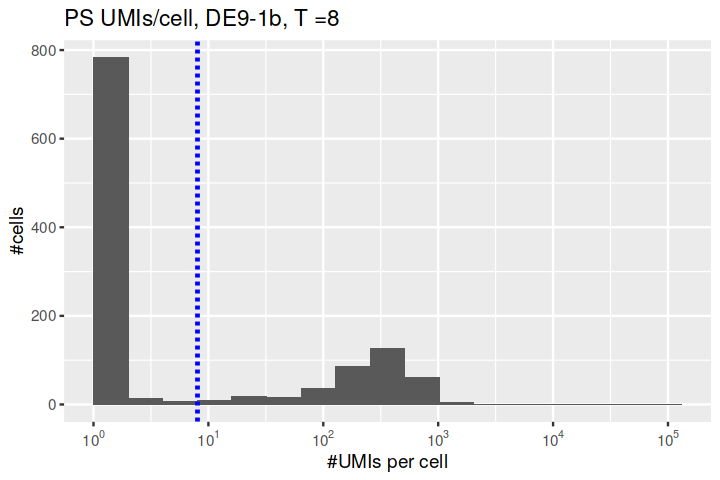

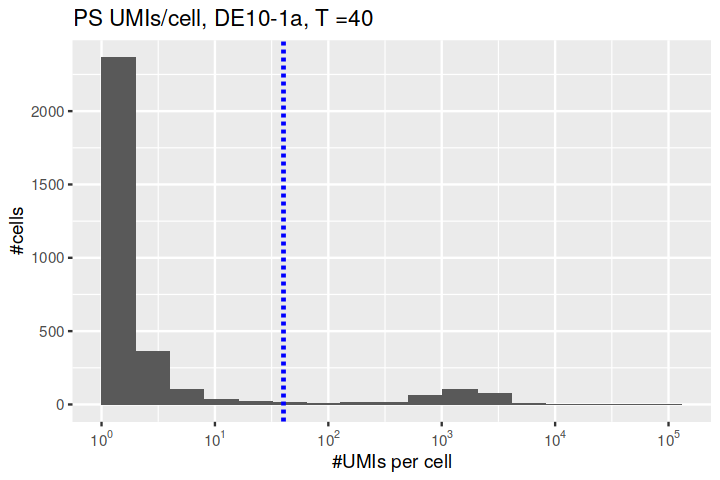

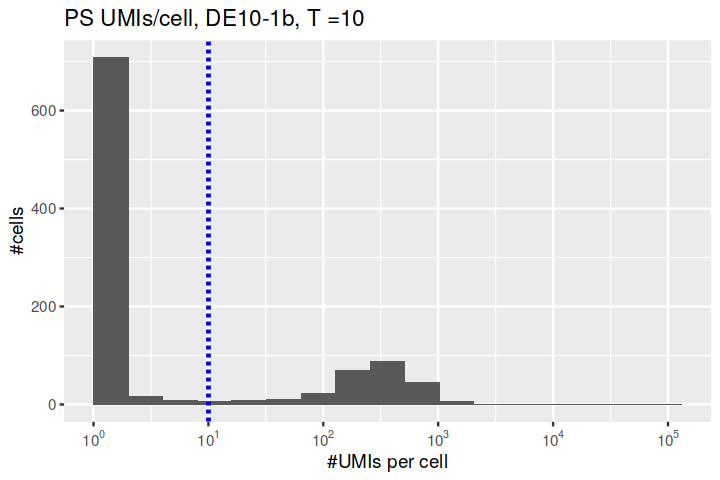

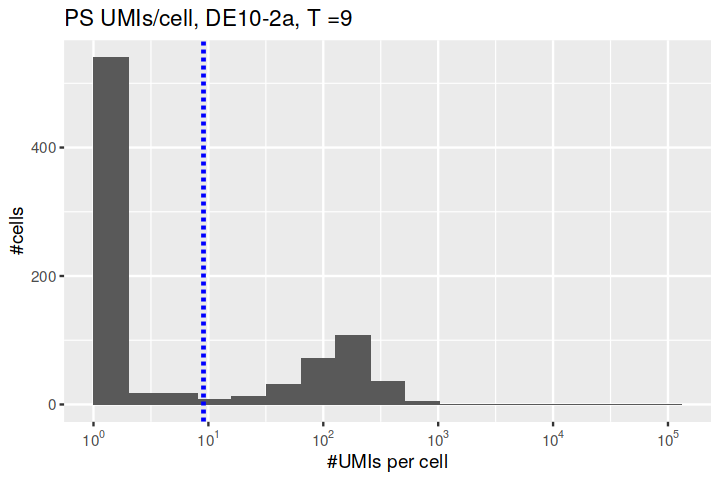

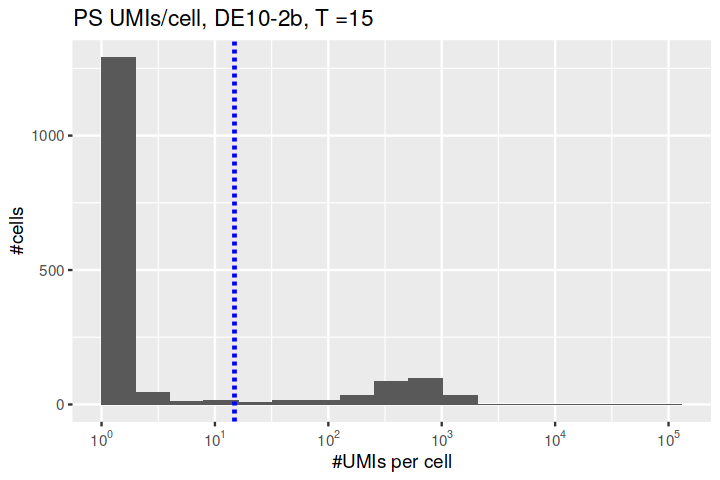

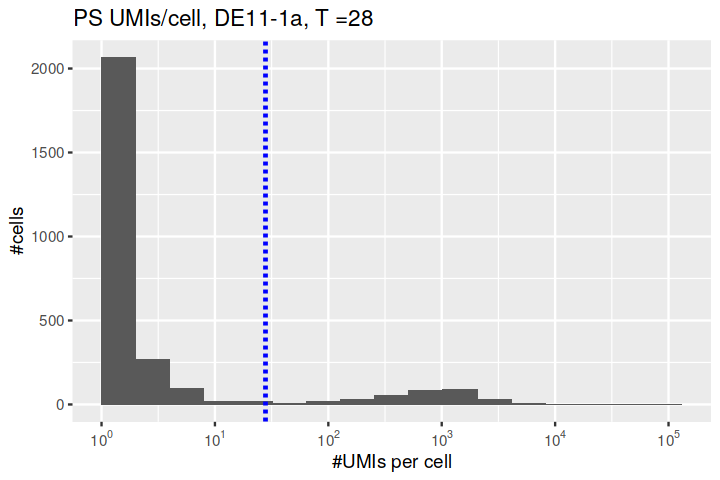

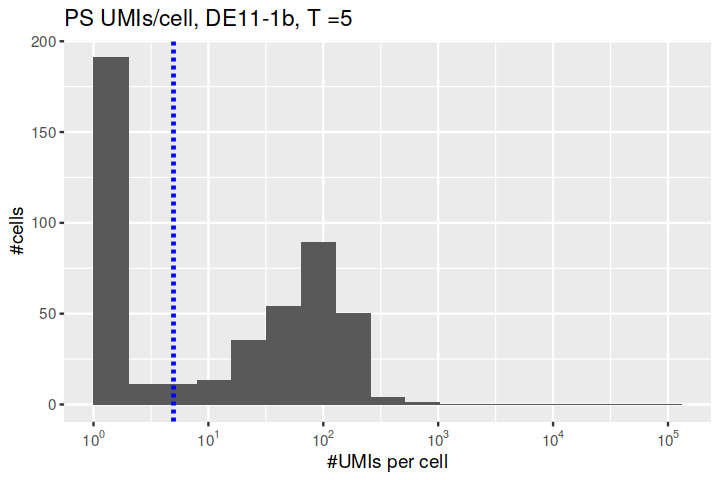

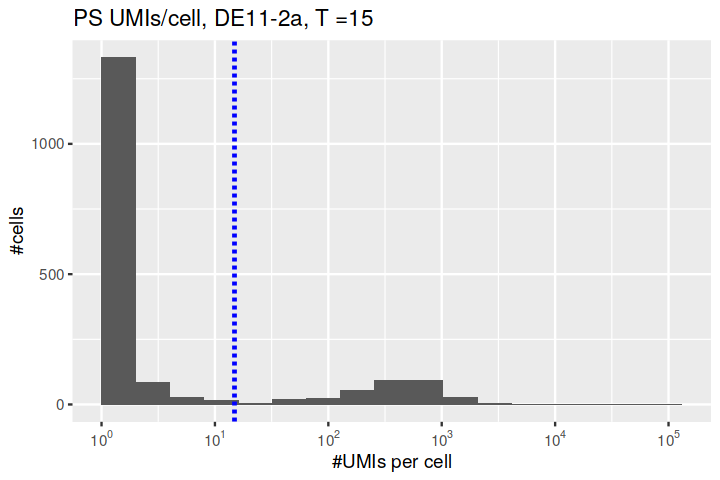

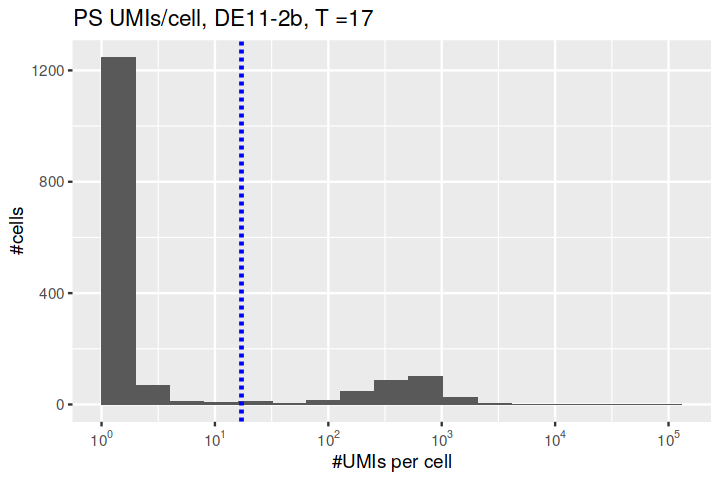

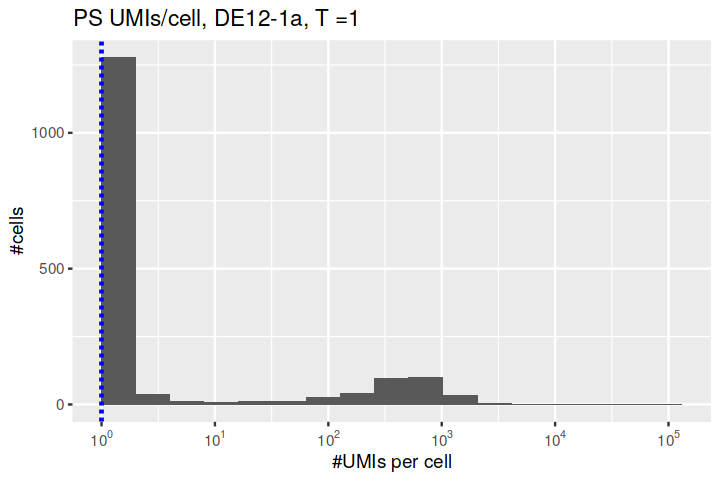

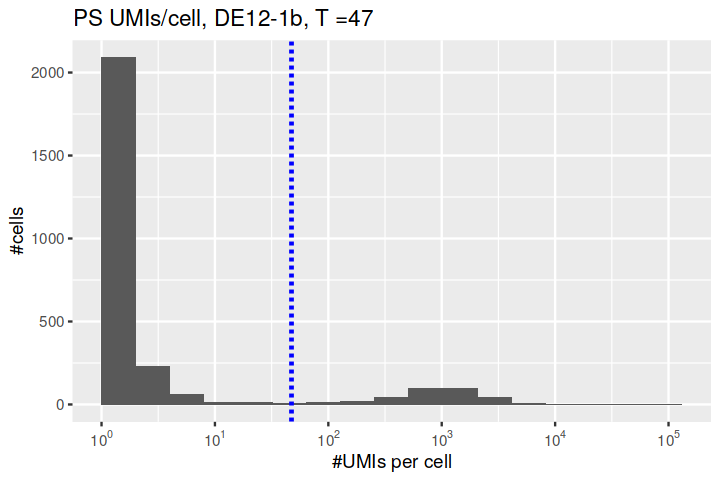

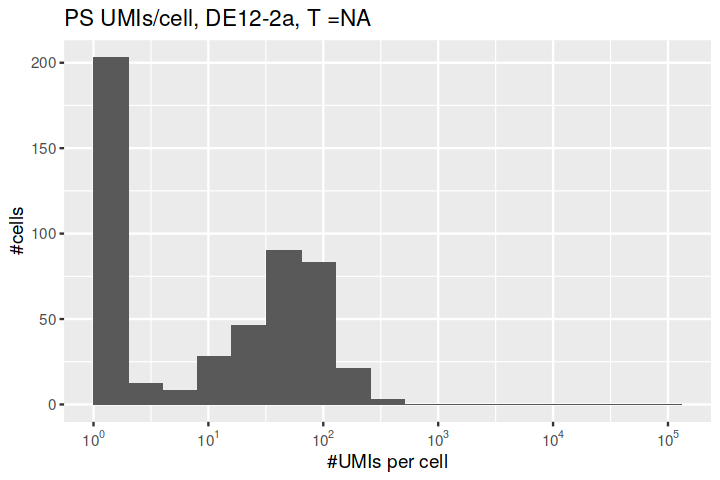

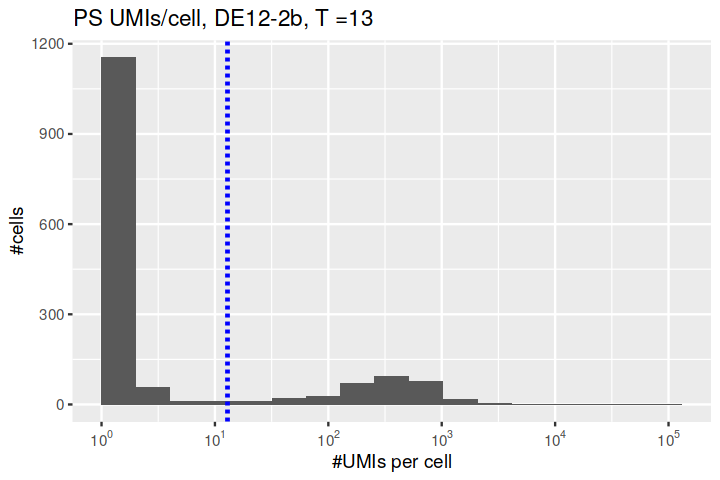

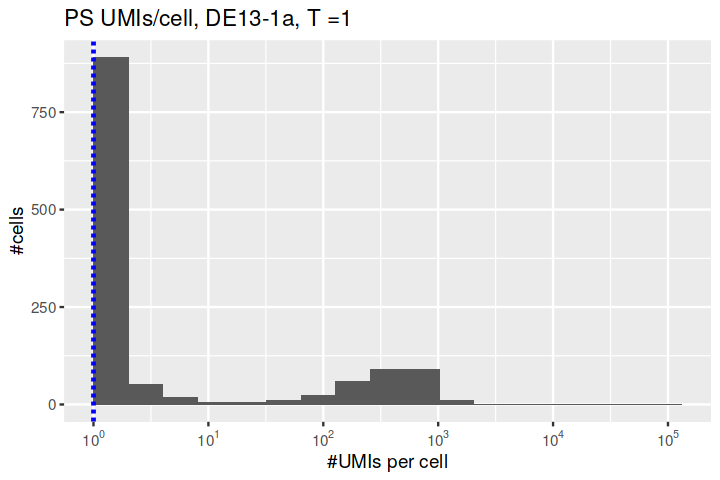

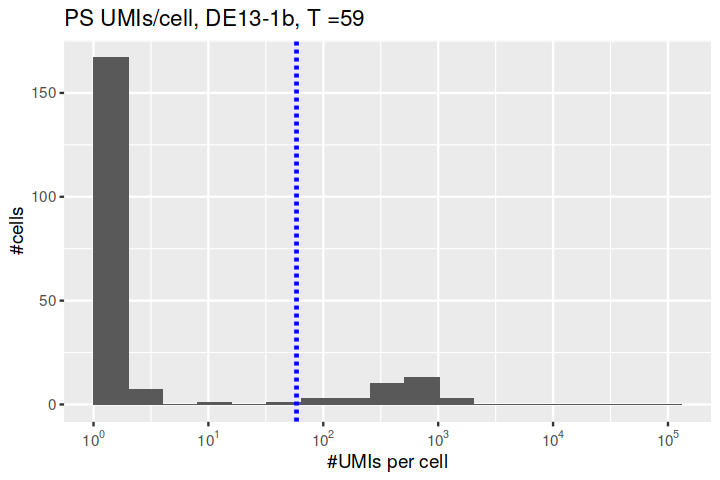

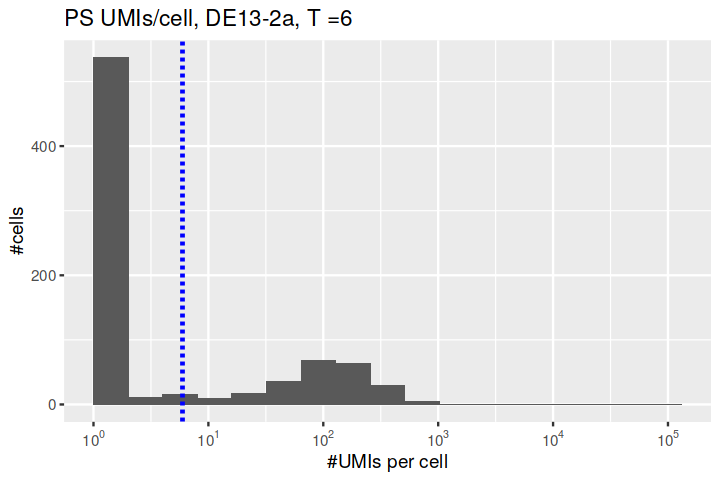

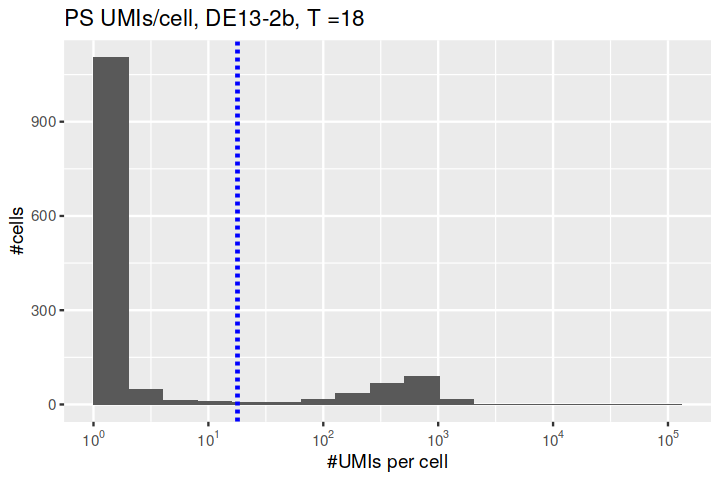

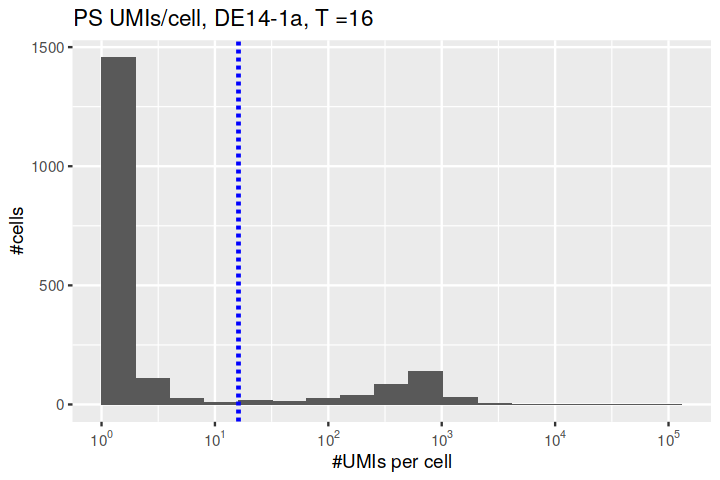

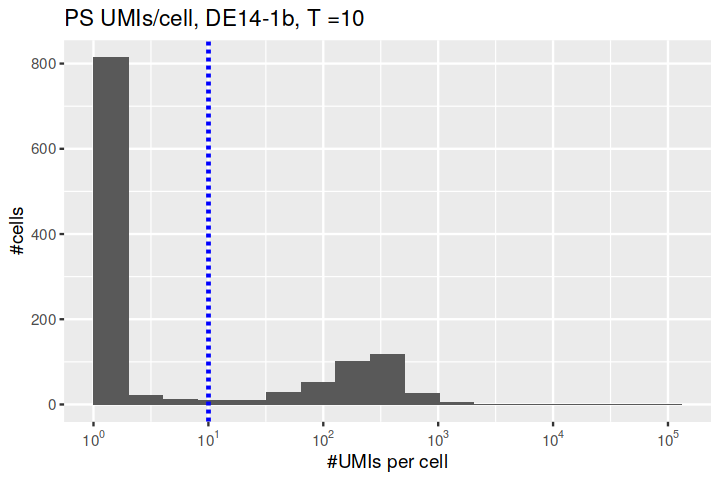

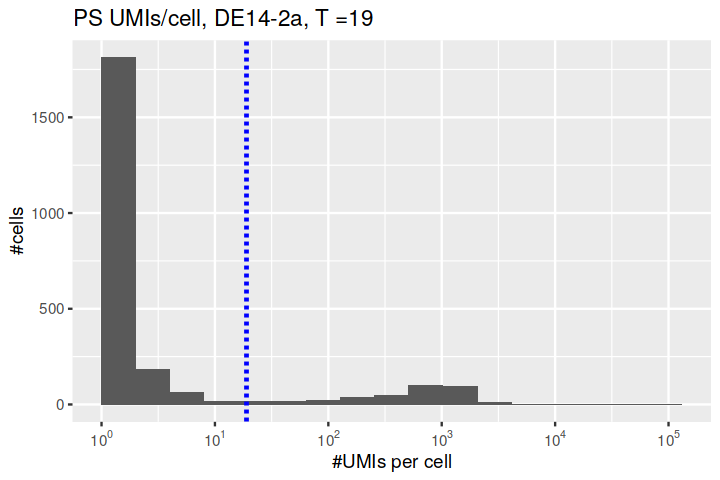

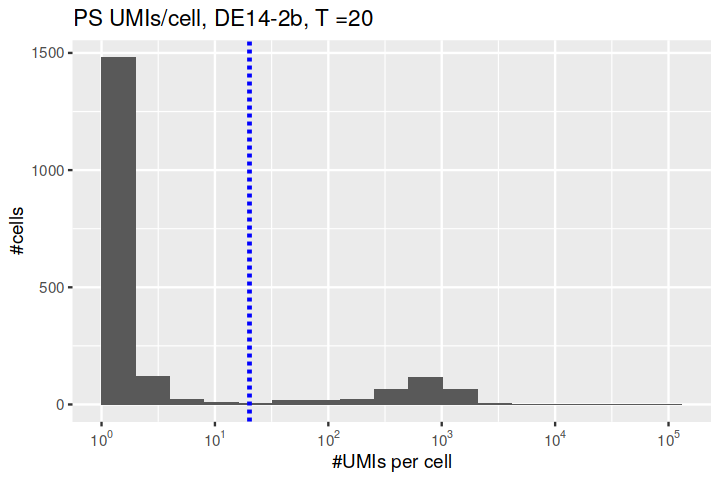

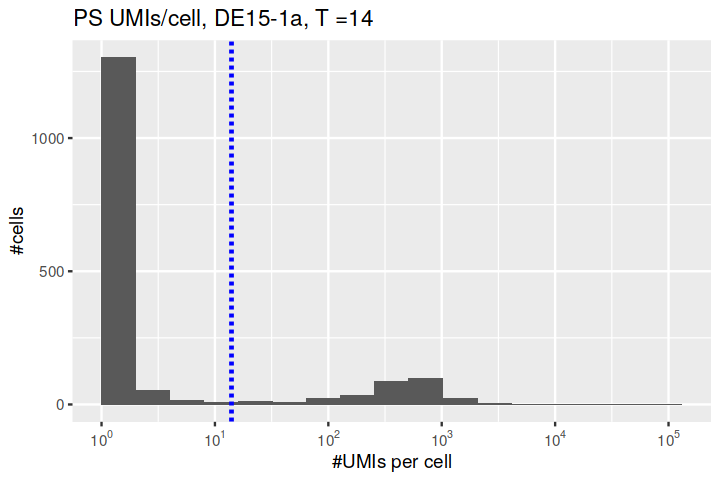

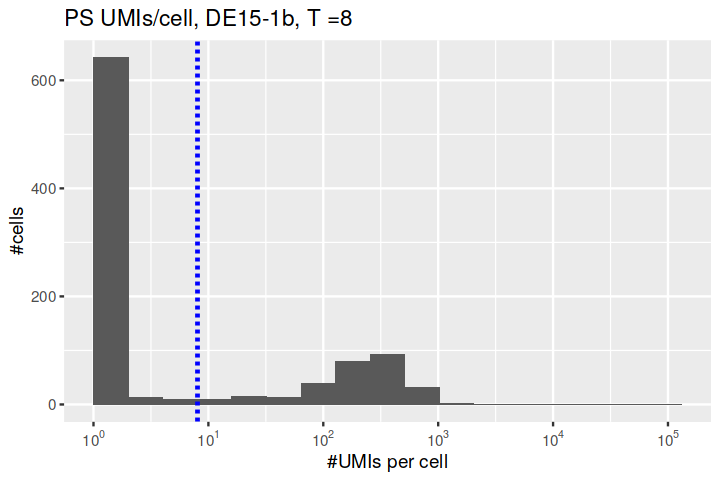

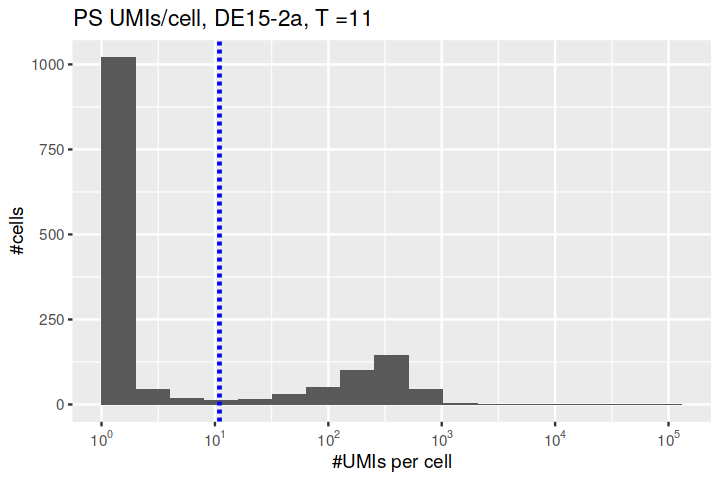

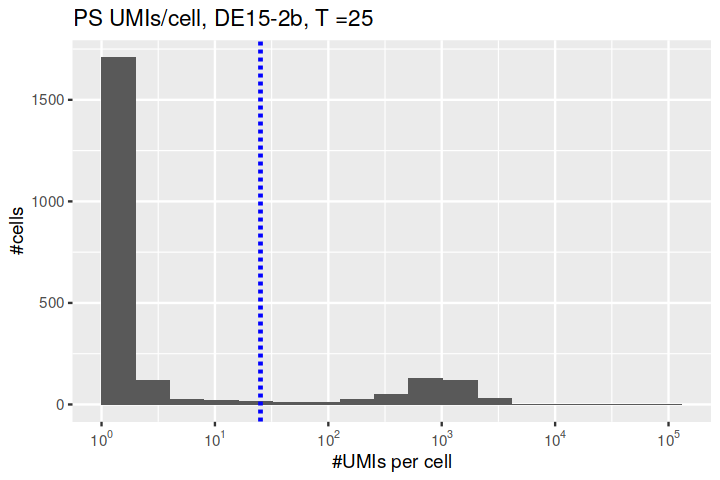

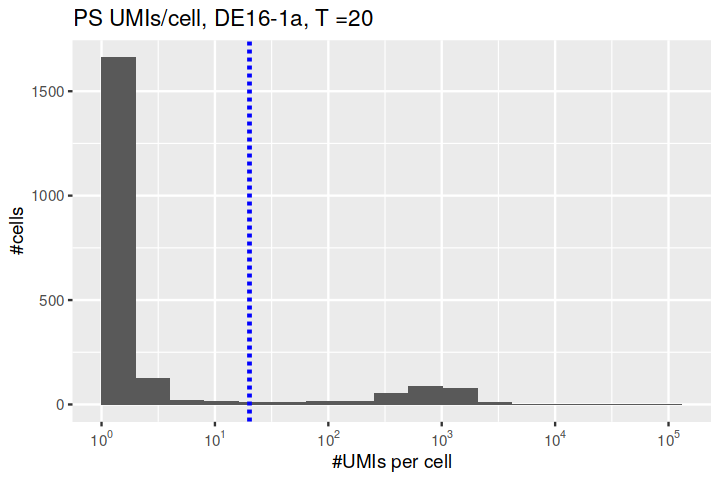

Skipping DE16-2a 


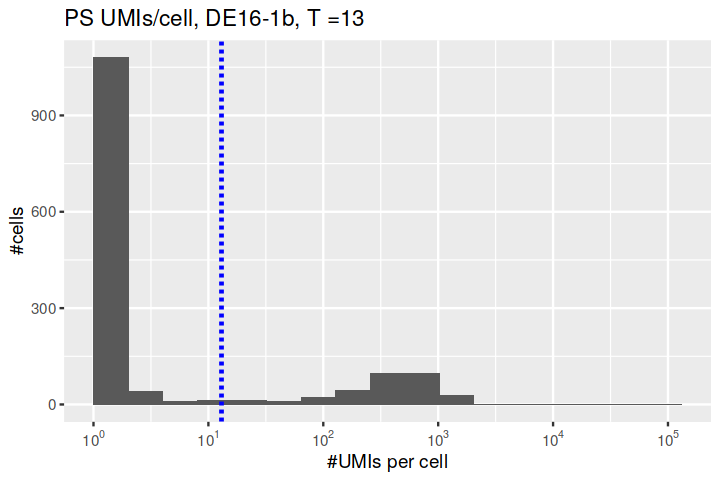

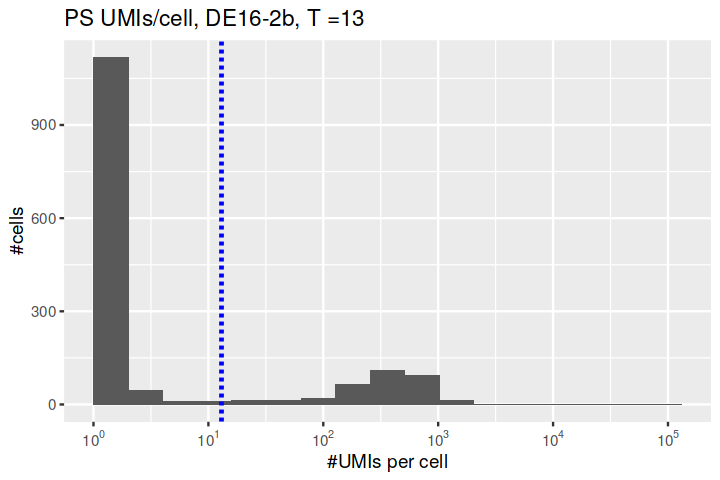

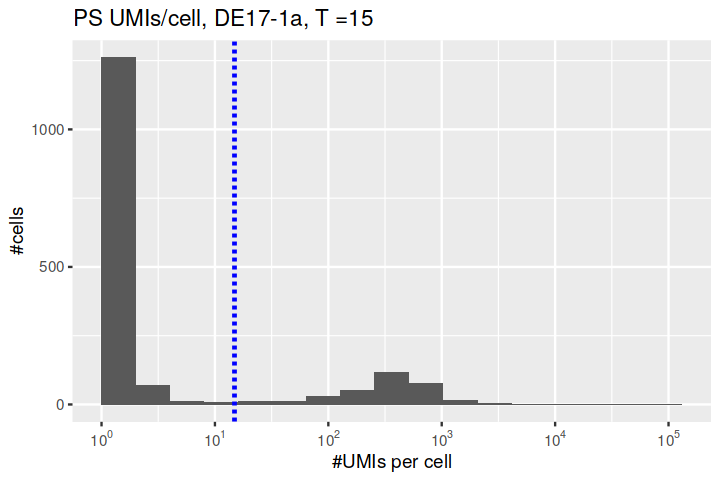

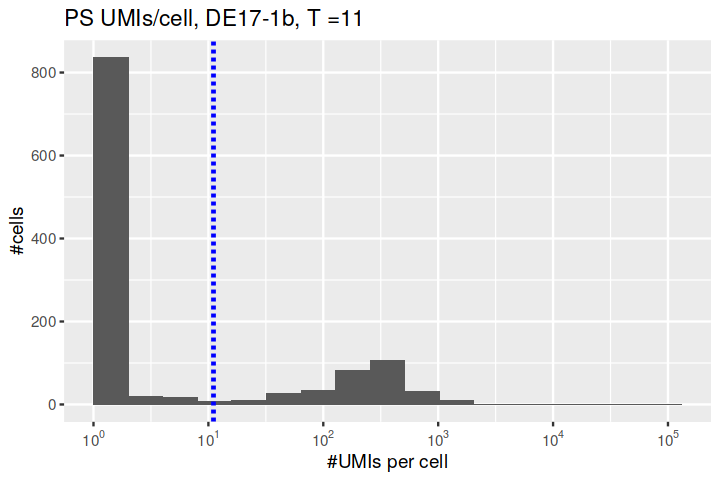

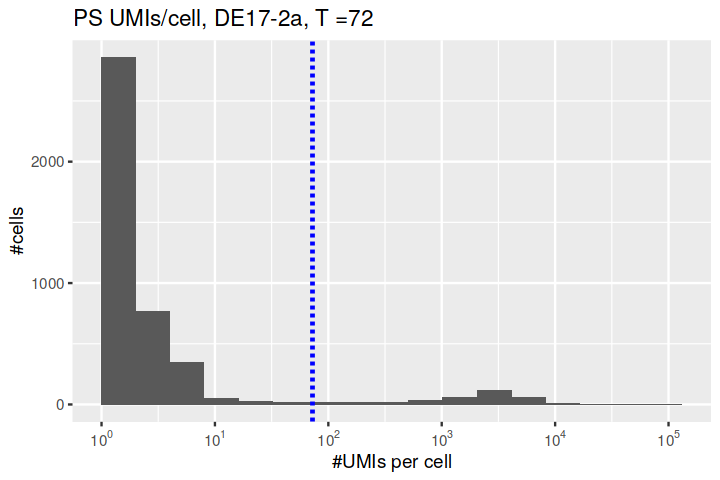

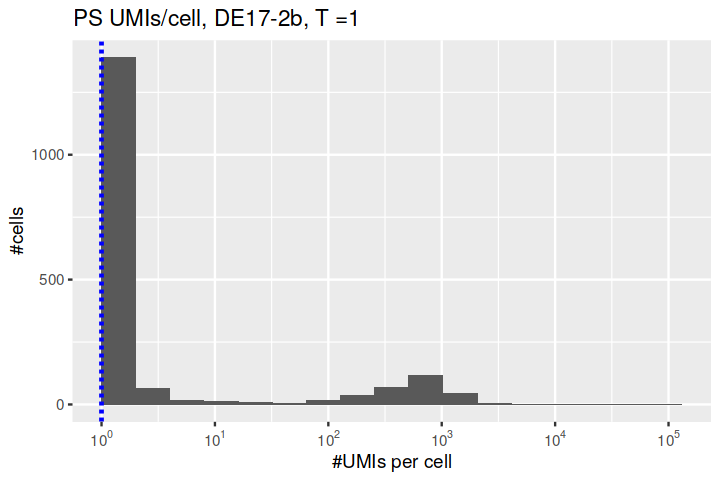

Skipping NTCE1-1b 
Skipping NTCE2-1a 
Skipping NTCE2-1b 


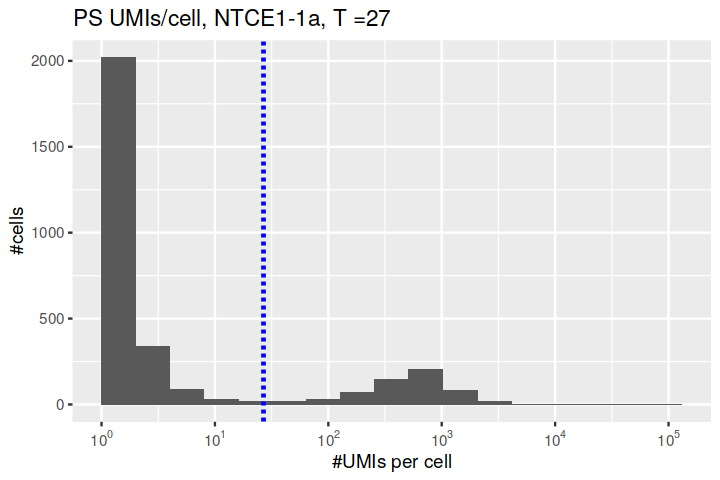

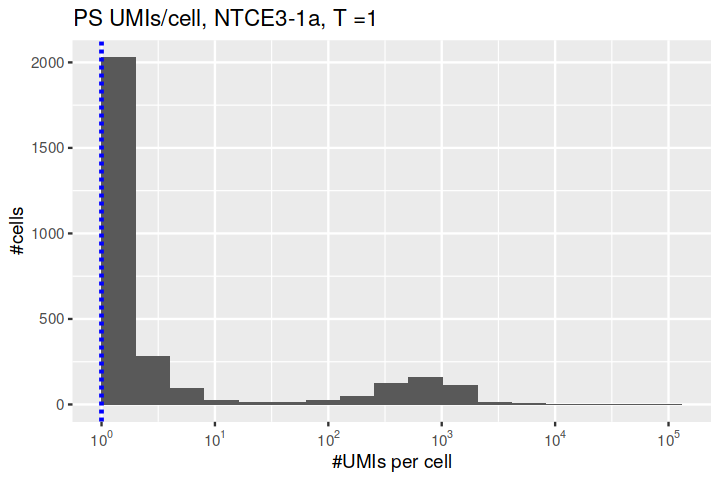

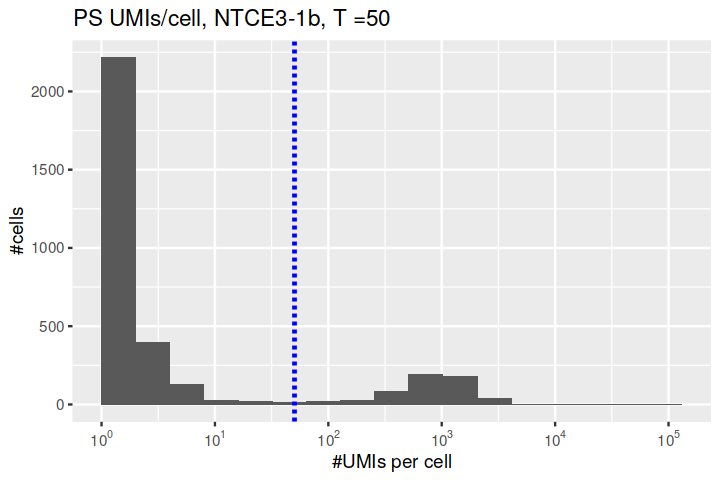

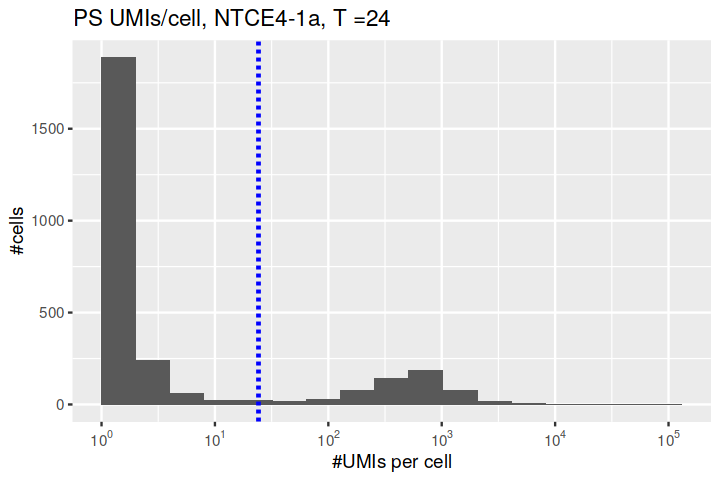

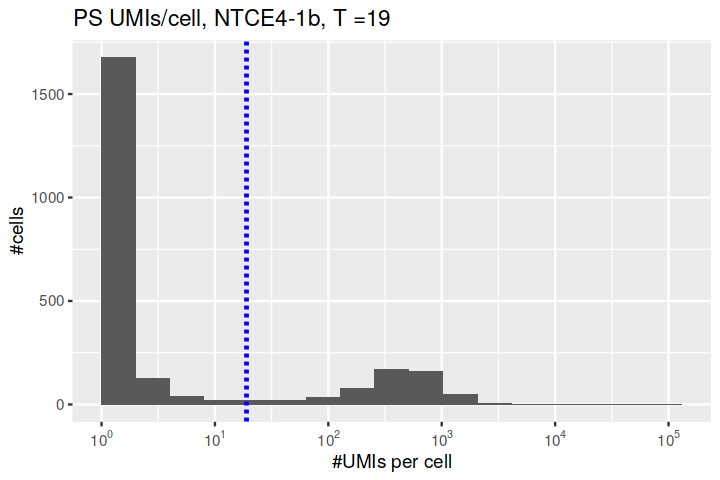

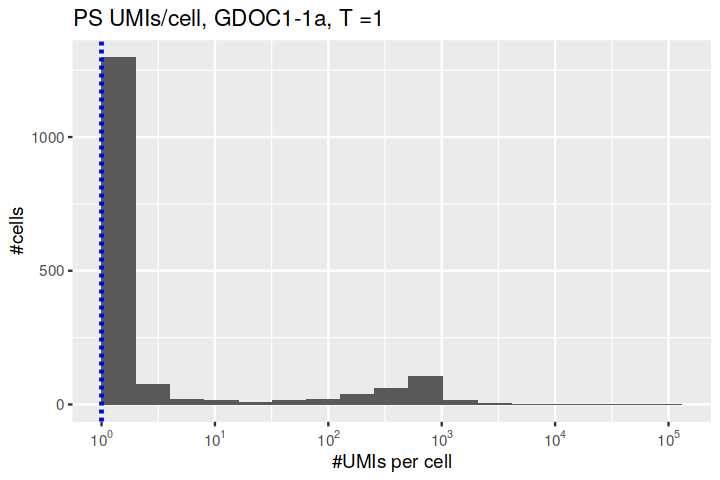

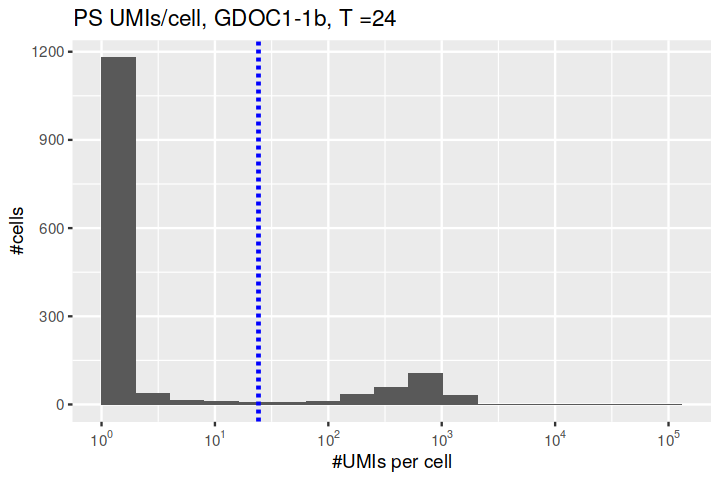

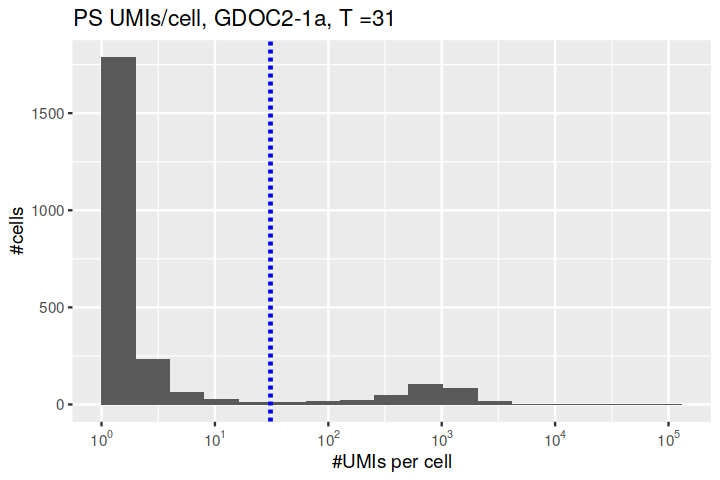

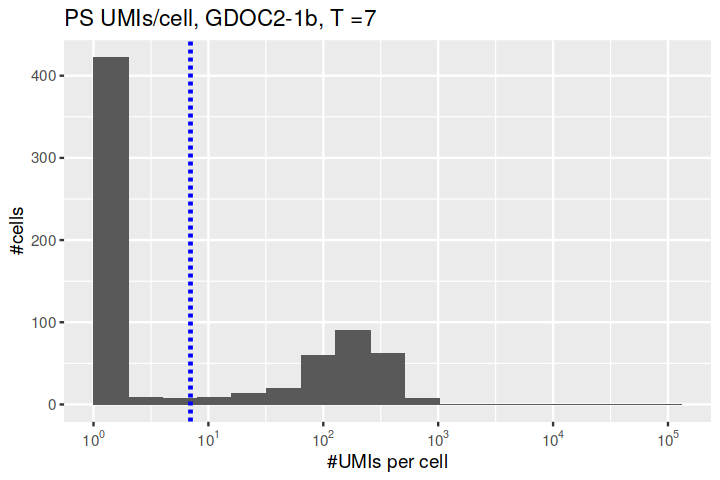

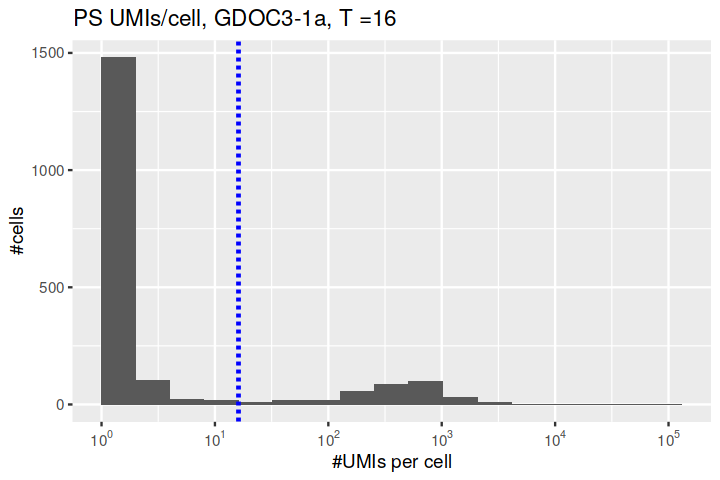

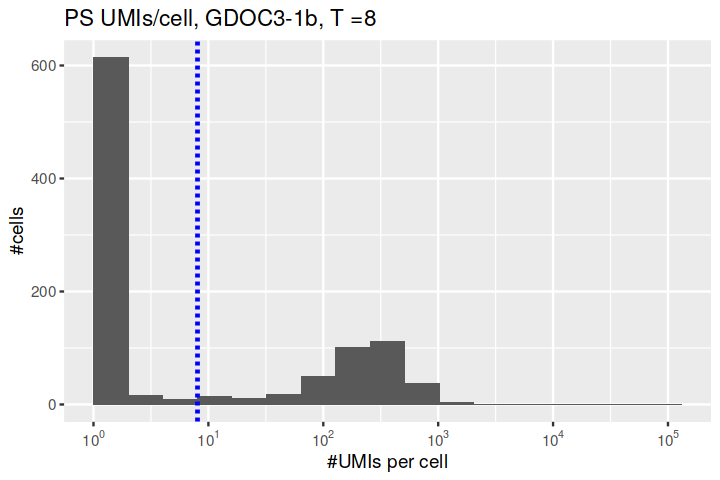

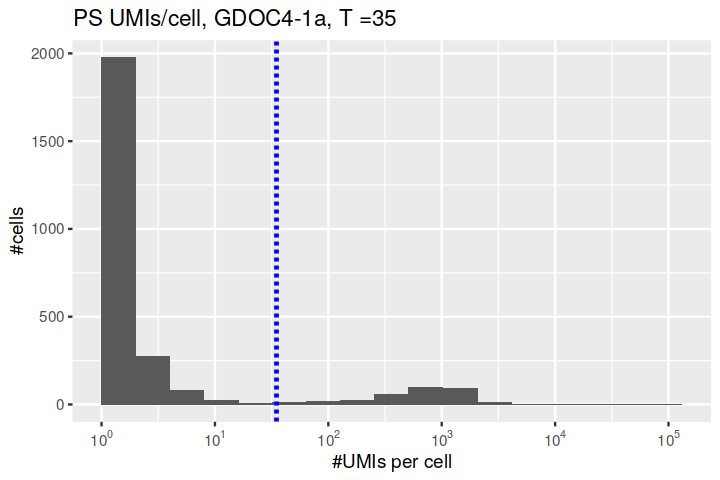

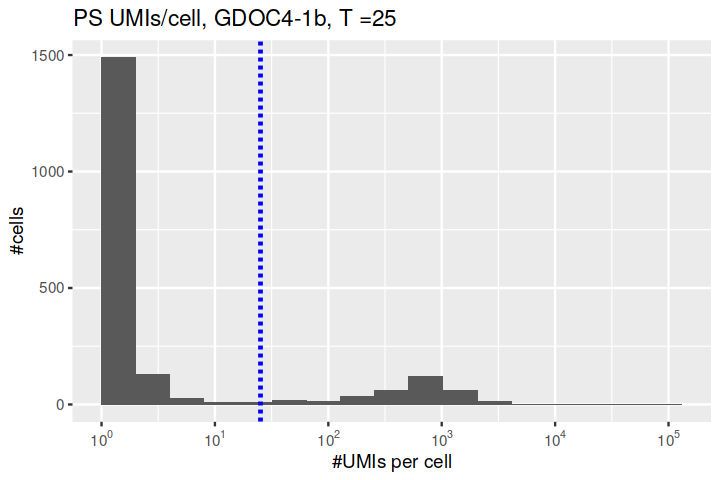

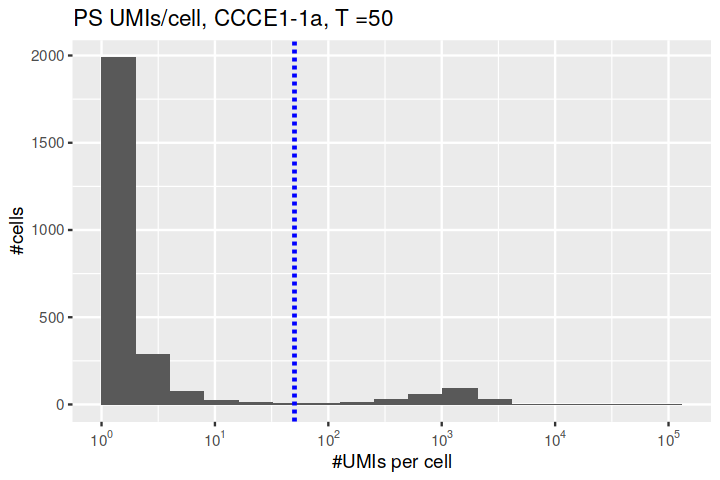

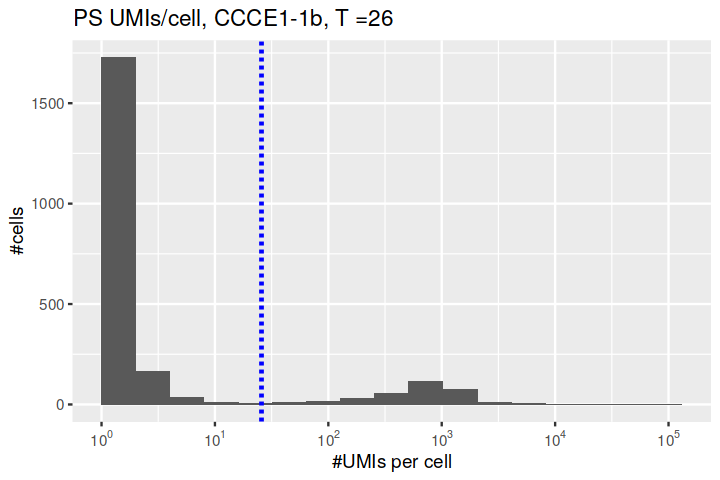

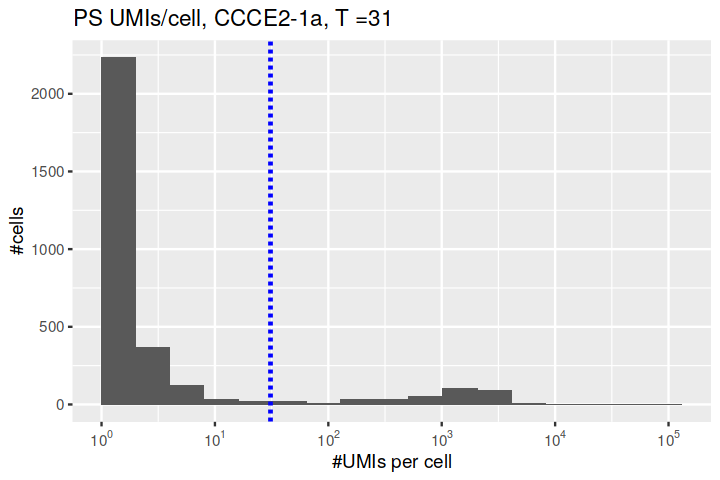

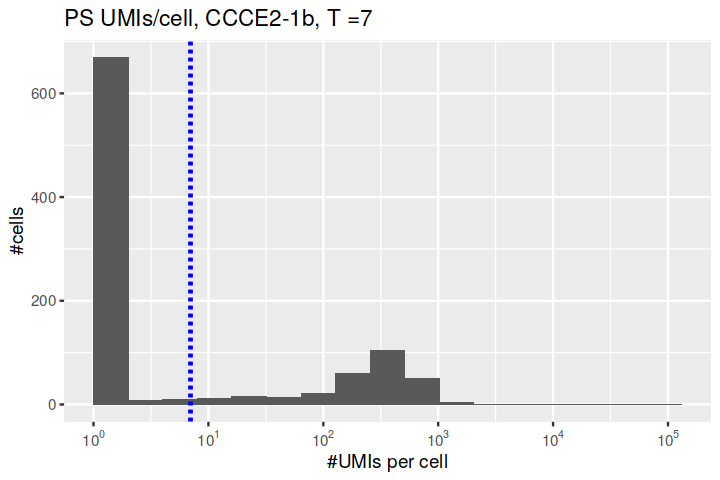

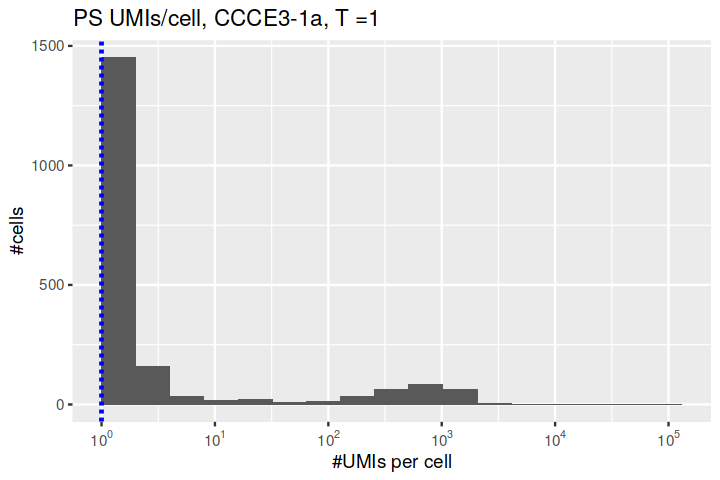

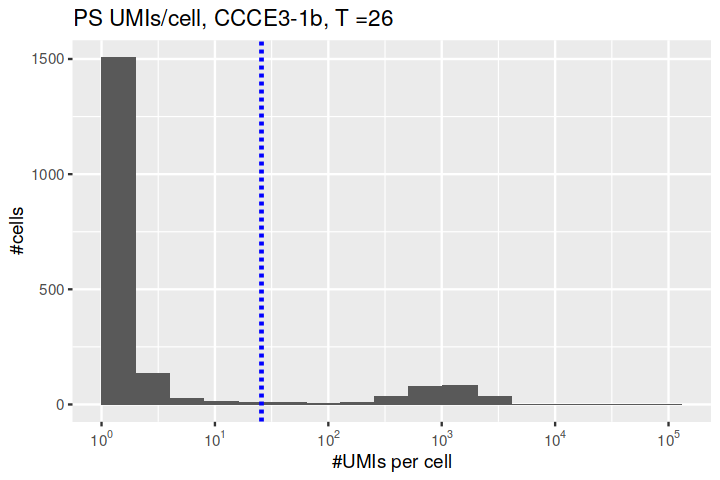

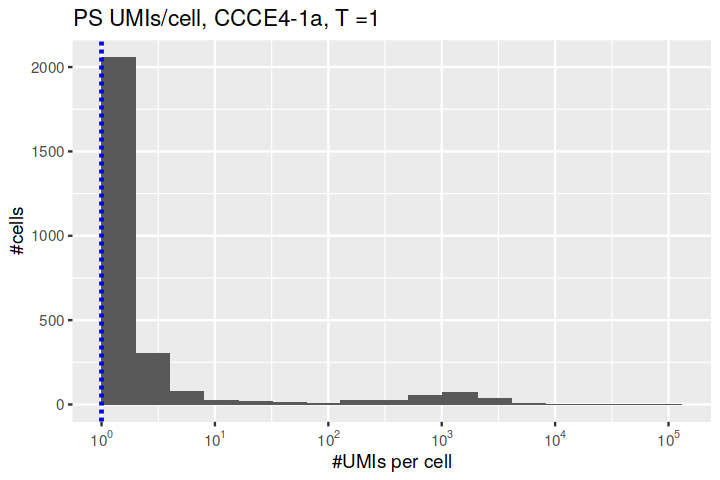

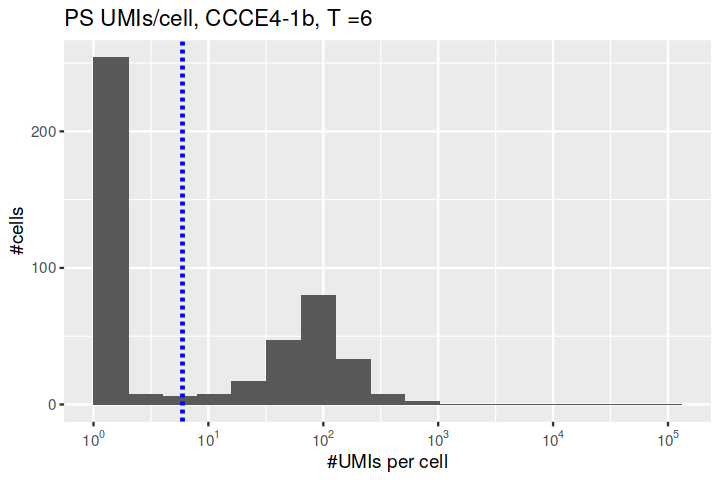

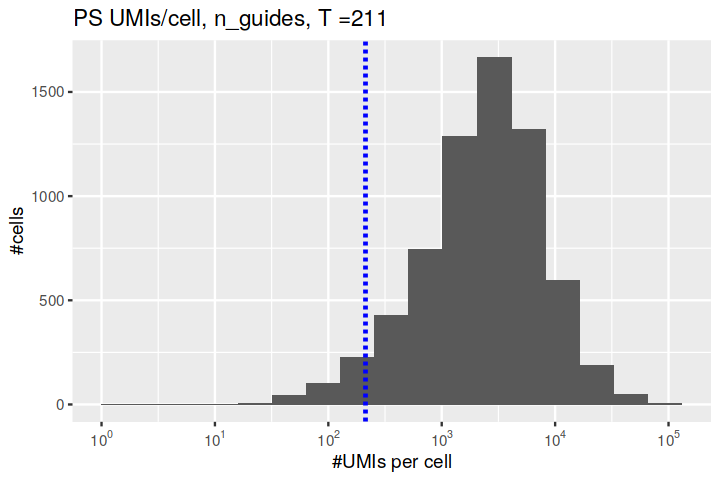

In [197]:
CUTOFF_PROB = 0.5
guides = colnames(df_guide_counts)

for(guide in guides) {
    y = df_guide_counts[,guide]
    select_nonzeros = y > 0
    y = y[select_nonzeros]
    if(length(y) == 0) {
        cat("Skipping", guide, "\n")
        next
    }
    log_y = log(y, 2)
    calls <- pgmix_mini(log_y)
    df_calls = as.data.frame(calls)
    df_calls['counts'] = log_y
    colnames(df_calls) = c('call', 'prob', 'log_count')
    options(repr.plot.width=4, repr.plot.height=4)
    head(df_calls)
    dim(df_calls)
    select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB
    # hist(df_calls$call)
    #plot(df_calls$call, df_calls$prob)

    df_gauss = df_calls[select_gaussian_assigned,]
    dim(df_gauss)
    
    # head(df_gauss)
    threshold = 2^min(df_gauss$log_count)
    #cat("threshold=", threshold)
    filter_y = y > 0
    y_filtered = y[filter_y]
    df_y = as.data.frame(y_filtered)
    head(df_y)
    
    options(repr.plot.width=6, repr.plot.height=4)
    bin_breaks <- c(1,2,2*2^(1:16))
    title = paste0("PS UMIs/cell, ", guide, ", T =", threshold)

    ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
    geom_histogram(breaks=bin_breaks) + 
    scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
    labs(title=title, x="#UMIs per cell", y="#cells") +  geom_vline(aes(xintercept=threshold), color="blue", linetype="dashed", size=1)

    print(ggp1)
    #print(guide)
}

In [198]:
guides

[1] "CD13-1a"     "CD13-1b"     "CD55-1a"     "CD55-1b"     "CD73-1a"    
  [6] "CD73-1b"     "FUBP1-1a"    "FUBP1-1b"    "C15orf40-1a" "C15orf40-1b"
 [11] "MAFF-1a"     "MAFF-1b"     "FTH1-1a"     "FTH1-1b"     "FTH1-2a"    
 [16] "FTH1-2b"     "PLIN3-1a"    "PLIN3-1b"    "PLIN3-2a"    "PLIN3-2b"   
 [21] "TKT-1a"      "TKT-1b"      "TKT-2a"      "TKT-2b"      "LGALS3-1a"  
 [26] "LGALS3-1b"   "LGALS3-2a"   "LGALS3-2b"   "CSTB-1a"     "CSTB-1b"    
 [31] "CSTB-2a"     "CSTB-2b"     "CTSB-1a"     "CTSB-1b"     "CTSB-2a"    
 [36] "CTSB-2b"     "KLF6-1a"     "KLF6-1b"     "KLF6-2a"     "KLF6-2b"    
 [41] "DE1-1a"      "DE1-1b"      "DE1-2a"      "DE1-2b"      "DE2-1a"     
 [46] "DE2-1b"      "DE2-2a"      "DE2-2b"      "DE3-1a"      "DE3-1b"     
 [51] "DE3-2a"      "DE3-2b"      "DE4-1a"      "DE4-1b"      "DE4-2a"     
 [56] "DE4-2b"      "DE5-1a"      "DE5-1b"      "DE5-2a"      "DE5-2b"     
 [61] "DE6-1a"      "DE6-1b"      "DE6-2a"      "DE6-2b"      "DE7-1a"     
 [66] "DE7-1b"      "DE7-2a"      "DE7-2b"      "DE8-1a"      "DE8-1b"     
 [71] "DE8-2a"      "DE8-2b"      "DE9-1a"      "DE9-1b"      "DE9-2a"     
 [76] "DE9-2b"      "DE10-1a"     "DE10-1b"     "DE10-2a"     "DE10-2b"    
 [81] "DE11-1a"     "DE11-1b"     "DE11-2a"     "DE11-2b"     "DE12-1a"    
 [86] "DE12-1b"     "DE12-2a"     "DE12-2b"     "DE13-1a"     "DE13-1b"    
 [91] "DE13-2a"     "DE13-2b"     "DE14-1a"     "DE14-1b"     "DE14-2a"    
 [96] "DE14-2b"     "DE15-1a"     "DE15-1b"     "DE15-2a"     "DE15-2b"    
[101] "DE16-1a"     "DE16-1b"     "DE16-2a"     "DE16-2b"     "DE17-1a"    
[106] "DE17-1b"     "DE17-2a"     "DE17-2b"     "NTCE1-1a"    "NTCE1-1b"   
[111] "NTCE2-1a"    "NTCE2-1b"    "NTCE3-1a"    "NTCE3-1b"    "NTCE4-1a"   
[116] "NTCE4-1b"    "GDOC1-1a"    "GDOC1-1b"    "GDOC2-1a"    "GDOC2-1b"   
[121] "GDOC3-1a"    "GDOC3-1b"    "GDOC4-1a"    "GDOC4-1b"    "CCCE1-1a"   
[126] "CCCE1-1b"    "CCCE2-1a"    "CCCE2-1b"    "CCCE3-1a"    "CCCE3-1b"   
[131] "CCCE4-1a"    "CCCE4-1b"    "n_guides"

In [199]:
df_guide_counts[,'PLIN3-1b']

[1]    0    0    0    0    1    0    0    1    1    1    0    0    0    0
  [15]    1    1    0    0    0    0    0    0    0    0    0    0    0    0
  [29]    0    0    2    0    0    2    1    1    0    0    0    0    0    1
  [43]    0    0    0    1    0    1    0    1    0    0    0    0    0    0
  [57]    0    0    0    0    0    0    0    0    0    0    1    0    0    0
  [71]    0    0    0    0    1    0  760    0    0    0    1    0    0    0
  [85]    0    0    4    0    0    2    0    0    1  512    0    1    0    1
  [99]    0    0    0    1    1    0    0    2    1    0    1    0    2    0
 [113]    0    2    1    0  110    1    0    0    1  873    0    0    0  213
 [127]  718 1240 2268  227  417 1074    1    0    2    1    0    1    0    1
 [141]    2    3    0    0    1    0    0    0    0    2    0    0    0    1
 [155]    1    0    0    0    0    3    0    0    1    1    1    0    0    2
 [169]    0    0    0    1    0    0    1    0    0    0    1    0    0    0
 [183]    1    0    0    0    1    0    2    1    0    0    1    0    0    0
 [197]    1    1    0    0    2    0    0    0  313  482  949    1    0    0
 [211]    0    0    0    0    0    0    0    0    1    0    0    2    0    2
 [225]    0    0    0    0    0    1    0    0    0    1    0    0    0    0
 [239]    0    0    0    0    0    0    0    0    2    0    1    0    0    1
 [253]    0  365    1    0    0    0    0    2    0    0    0    0    0    0
 [267]    0    1    0    0    1   54  510    4    1    0    0    0    0    1
 [281]    1    0    0    4    1    0    1    1    0    0    0    0    0    0
 [295]    0    0    0    2    0    0    0    2    0    1    0    1    0    0
 [309]    0    0    0    0    0    0    0    1    0    0    0    0    0    0
 [323]    0    0    0    0    0    0    0    0    3    0    0    0    0    1
 [337]    0    0    1    0    0    0    0    0    0    0    0    0    1    0
 [351]    2    1    0    0    1    1    0    0    0    0    0    0    0    0
 [365]    0    0    0    0    0    0    1    0    0    1    0    0    1    0
 [379]    2    0    0    0    0    0    0    1    1    0    1    0    0    0
 [393]    0    0    0    1    1    0    0    0    0    1    0    0    0    0
 [407]    0    1    0    1    1    2    0 2056    0    0    0    2    0    0
 [421]    0    0    0    0    1    0    2    0    0    0    1    0    1    1
 [435]    2    1    0    1    2    2    0    0    1  225    2    1    0    3
 [449]  927  857  111  720    0  900    5    1    0    0    0    1    0    0
 [463]    0    3    2    0    0    1    1    0    1    0    0    0    1    0
 [477]    1    1    0    0    0    0    0    0    0    0    0    0    0    0
 [491]    0    0    0    0    0    1    0    0    0    0    0    2    0    1
 [505]    0    0    0    0    1    1    0    0    0    0    2    0    0    0
 [519]    0    3    0    1    0    0    0    0    0    0    0    0    0    1
 [533]    0  711    0    1    1    0    0    0    0    0    0  345 2019    1
 [547]    0    0    0    0    1  542    0    1    1    0    1    2    2    0
 [561]    1    0    0    1    1    3    0    0    0    0    0    0    2    0
 [575]    0    0  833    0    0    0    0    0    1    0    0    0    5    0
 [589]  637 1570  125    0    1    0    0    0    1    3    0    0    1    0
 [603]    0    1    0    0    1 2710    0  507    0    1    5    0    0  820
 [617]    3    1    1    0  326    0  363    0    0    1    0    0    0    1
 [631]    0    2    0    0    1    0    0    1    0    0    0    3    0    0
 [645]    2    0    1    0    0    0    0    0    0    0    3    1    0    0
 [659]    0    0    0   11 2911    0    1    0    0    1    0    0    3    0
 [673]    0    0    0    0    0    0    0    1    0    1    0    1    0    1
 [687]    0    1  342  389    0    0    0    0    0    3    0    0    3    1
 [701]    0    0   36    0    0    0 1141  789    0  873    0  291    0    1
 [715]    0    1    1    0    0    0    0    0    2    1    2    0    0    1